# **Part 5 -- The h-indices data**

_Foreword_

The goal of this notebook is to explore and visualize the h-indices data.

IMPORTING LIBRARIES

Before we get started, let's import all necessary libraries for performing our data analysis:

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from scipy import stats
import re
import nltk
import missingno as msno
from tqdm import tqdm
import json
import statistics
import math

nltk.download("stopwords", quiet=True)
from nltk.corpus import stopwords
from gensim.models import Phrases
from collections import Counter

# enabling Jupyter Lab to include the output of our plots directly in this notebook
%matplotlib inline


# used to avoid blurry output plots in Jupyter Notebooks
%config InLineBackend.figure_format = "retina"

pd.options.mode.chained_assignment = None

__Download of the data__

In [2]:
infile_df_hindices = open('../creation_data_and_variables/data_creation_variables/df_h_indices','rb')
df_hindices = pickle.load(infile_df_hindices)
infile_df_hindices.close()

In [3]:
infile_df_full = open('data_exploratory_analysis/df_full_cleaned','rb')
df_full = pickle.load(infile_df_full)
infile_df_full.close()

THE DATASET

This dataset contains information about the authors of all the papers published from the first of January 2002 to the 31st of December 2022 related to our list of concepts. 

More specifically, the dataset contains the following information for each paper:
- ```author```: the author we are considering (and more specifically its id OpenAlex)
- ```year```: the year we are considering for the information about the author
- ```month```: the month we are considering for the information about the author
- ```yearly_H_index_notincremental```: the h-index of the author composed of only the citations he received during the year in question for all the papers he already published
- ```yearly_H_index_incremental```: the h-index of the author composed of all the citations he received until the year in question for all the papers he already published
- ```monthly_H_index_incremental```: the h-index of the author composed of all the citations he received until the month for the year in question for all the papers he already published
- ```monthly_H_index_notincremental```: the h-index of the author composed of only the citations he received during the month if the year in question for all the papers he already published

_Sidenote_

Most of the h-indices are zero, since for all the authors we have information from January 2002 to December 2022, while many of them published papers not necessarily at the beginning of this period. For them, all information are zero until the time where he published anything. And then citations also take some time to come. In addition the ```monthly_H_index_notincremental``` is almost always zero. Furthermore, since at the beginning of the period, there are almost no citations within the period, the h-indices are almost always zero. For all these reasons we have a lot of zeroes.

Besides, one must keep in mind, that this h-index is an artificial h-index that only makes sense within the field of encryption technologies within the defined period of time.

<div class="alert-info">
1. First visualization of the data
</div>

In [4]:
df_hindices

author  year      month  \
0         https://openalex.org/A2800469661  2002    January   
1         https://openalex.org/A2800469661  2002   February   
2         https://openalex.org/A2800469661  2002      March   
3         https://openalex.org/A2800469661  2002      April   
4         https://openalex.org/A2800469661  2002        May   
...                                    ...   ...        ...   
45428035  https://openalex.org/A2763418023  2022     August   
45428036  https://openalex.org/A2763418023  2022  September   
45428037  https://openalex.org/A2763418023  2022    October   
45428038  https://openalex.org/A2763418023  2022   November   
45428039  https://openalex.org/A2763418023  2022   December   

          yearly_H_index_notincremental  yearly_H_index_incremental  \
0                                     0                           0   
1                                     0                           0   
2                                     0                           0   
3                                     0                           0   
4                                     0                           0   
...                                 ...                         ...   
45428035                              1                           2   
45428036                              1                           2   
45428037                              1                           2   
45428038                              1                           2   
45428039                              1                           2   

          monthly_H_index_incremental  monthly_H_index_notincremental  
0                                   0                               0  
1                                   0                               0  
2                                   0                               0  
3                                   0                               0  
4                                   0                               0  
...                               ...                             ...  
45428035                            2                               0  
45428036                            2                               0  
45428037                            2                               1  
45428038                            2                               0  
45428039                            2                               0  

[45428040 rows x 7 columns]

In [5]:
listauthor = list(set(df_full.author.tolist()))
len(listauthor)

180270

In [6]:
df_hindices.describe()

year  yearly_H_index_notincremental  \
count  4.542804e+07                   4.542804e+07   
mean   2.012000e+03                   1.295617e-01   
std    6.055301e+00                   4.650149e-01   
min    2.002000e+03                   0.000000e+00   
25%    2.007000e+03                   0.000000e+00   
50%    2.012000e+03                   0.000000e+00   
75%    2.017000e+03                   0.000000e+00   
max    2.022000e+03                   2.300000e+01   

       yearly_H_index_incremental  monthly_H_index_incremental  \
count                4.542804e+07                 4.542804e+07   
mean                 2.706514e-01                 2.505101e-01   
std                  8.663706e-01                 8.317419e-01   
min                  0.000000e+00                 0.000000e+00   
25%                  0.000000e+00                 0.000000e+00   
50%                  0.000000e+00                 0.000000e+00   
75%                  0.000000e+00                 0.000000e+00   
max                  4.200000e+01                 4.200000e+01   

       monthly_H_index_notincremental  
count                    4.542804e+07  
mean                     2.799971e-02  
std                      1.778776e-01  
min                      0.000000e+00  
25%                      0.000000e+00  
50%                      0.000000e+00  
75%                      0.000000e+00  
max                      9.000000e+00

<div class="alert-info">
2. Consideration of the types of the variables
</div>

In [7]:
df_hindices.dtypes

author                            object
year                               int64
month                             object
yearly_H_index_notincremental      int64
yearly_H_index_incremental         int64
monthly_H_index_incremental        int64
monthly_H_index_notincremental     int64
dtype: object

<div class="alert-info">
3. Unique values in my dataset
</div>

In [8]:
unique_values = df_hindices.select_dtypes(include=["object",'int64']).nunique()
unique_values

author                            180270
year                                  21
month                                 12
yearly_H_index_notincremental         22
yearly_H_index_incremental            43
monthly_H_index_incremental           43
monthly_H_index_notincremental        10
dtype: int64

<div class="alert-info">
4. Visualizing possible duplicates in my database
</div>

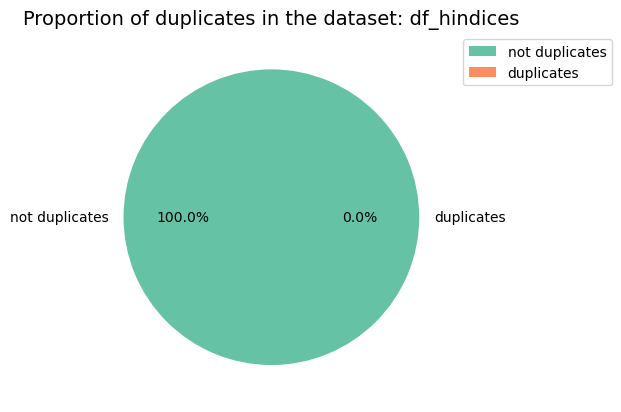

In [9]:
# little fancy visualization for df_hindices

df_hindices_noduplicates = df_hindices.drop_duplicates()

# data to be displayed
data = [len(df_hindices_noduplicates), len(df_hindices) - len(df_hindices_noduplicates)]

# labels for radability and intepretation
labels = ["not duplicates", "duplicates"]

# colors
colors = sns.color_palette("Set2")

# creating the pie chart
plt.pie(data, labels=labels, colors=colors, autopct="%0.1f%%")

# title
plt.title(
    "Proportion of duplicates in the dataset: df_hindices",
    color="black",  # I am using the 'white' color here, as I am using the 'dark mode' of Jupyter Lab.
    fontsize=14,
)

# legend
plt.legend(bbox_to_anchor=(1, 1))

# calling the pie chart
plt.show()

<div class="alert-info">
5. Visualization of missing values.
</div>

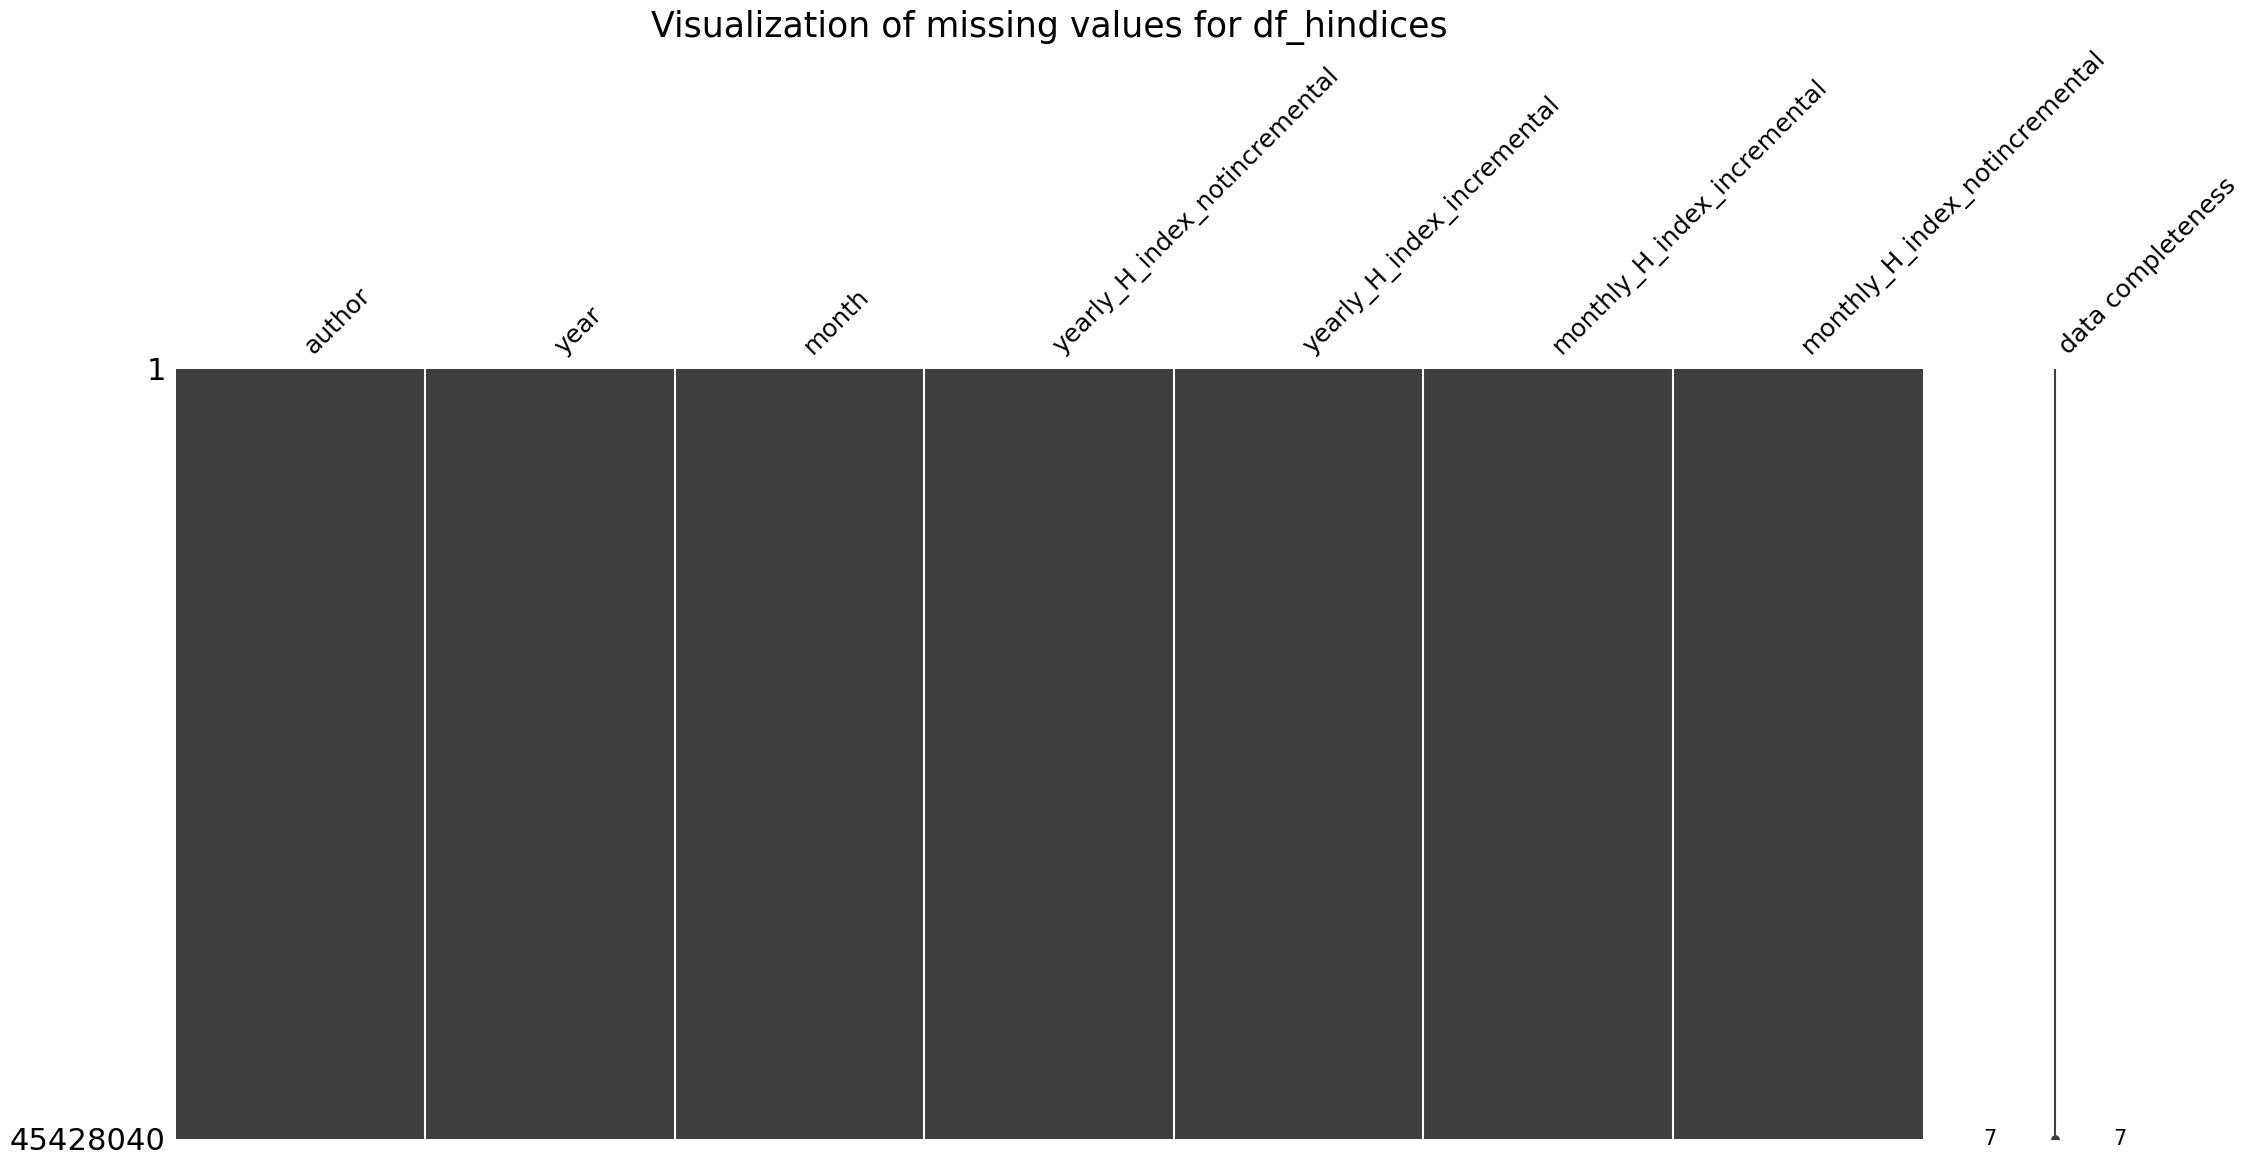

In [10]:
msno.matrix(df_hindices,labels=True, fontsize=18)
plt.title("Visualization of missing values for df_hindices",fontsize = 25)
plt.show()

__Observations__

So far so good there are no duplicates, no missing values, unique values are exactly as expected. Everything is just exactly as expected.

<div class="alert-info">
6. In depth visualization of the data and basic statistics
</div>

We'd like to see the distribution of the number of times authors have a certain "monthly_H_index_incremental".

In [11]:
# we save the several not incremental h-indices in a list and sort them
mylist = df_hindices.monthly_H_index_notincremental.tolist()
listuniquevalues = list(set(mylist))
mylist.sort()
listforlabel =[str(x) for x in listuniquevalues]

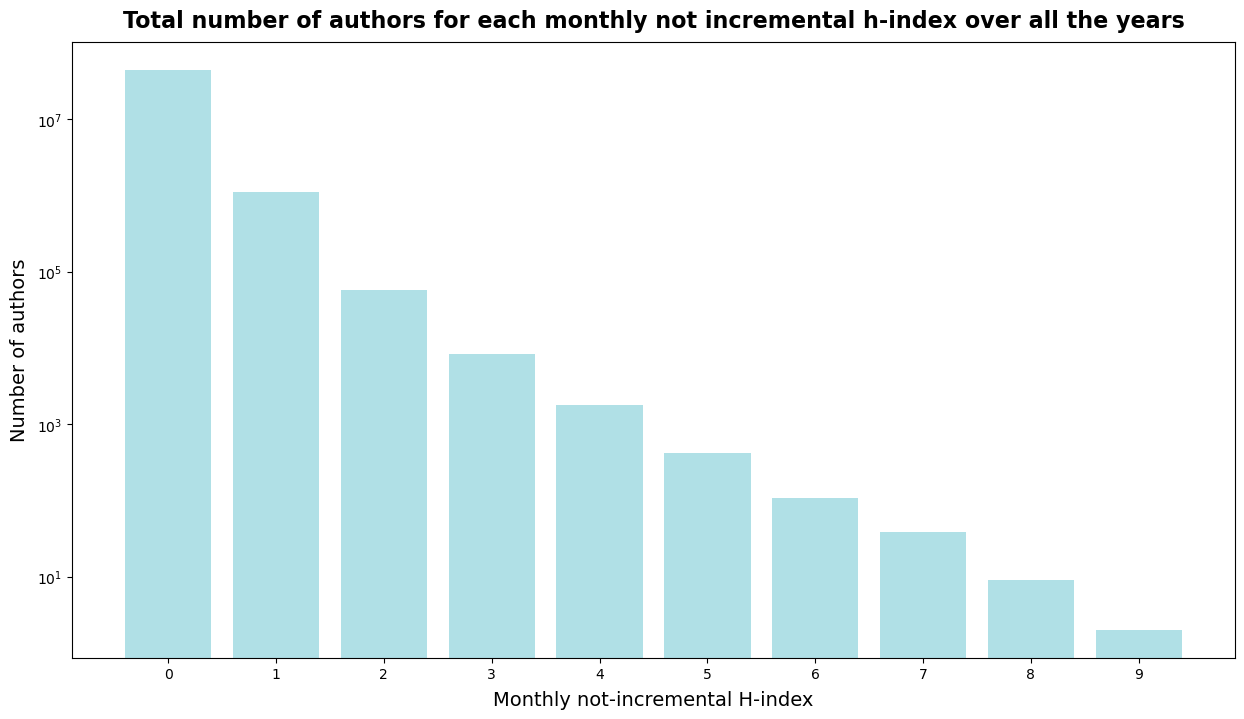

In [12]:
# lables and title specs
label_specs = {"fontsize": 14,"labelpad":6}
title_specs = {"fontsize": 16, "fontweight": "bold", "y": 1.01}

number_authors_byhindex = []
# we count how many times each h-index occurs
for element in listuniquevalues:
    specificlist = [x for x in mylist if x==element]
    number_authors_byhindex.append(len(specificlist))
    
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(8)

# score bar chat
# setting the axes of our horizontal bar plot

plt.bar(listforlabel, number_authors_byhindex, color="powderblue")  
# setting the column of our dataset ('number of papers') that we want to plot as a numerical variable

# setting the labels of our axes
plt.xlabel("Monthly not-incremental H-index",**label_specs)
plt.ylabel("Number of authors",**label_specs)
plt.yscale('log')

# setting the bar plot title
plt.title("Total number of authors for each monthly not incremental h-index over all the years",**title_specs)

# showing the bar plot (command not necessary, but it avoids to print the explanation text)
plt.show()

In [13]:
# we save the several incremental h-indices in a list and sort them
mylist = df_hindices.monthly_H_index_incremental.tolist()
listuniquevalues = list(set(mylist))
mylist.sort()
listforlabel =[str(x) for x in listuniquevalues]

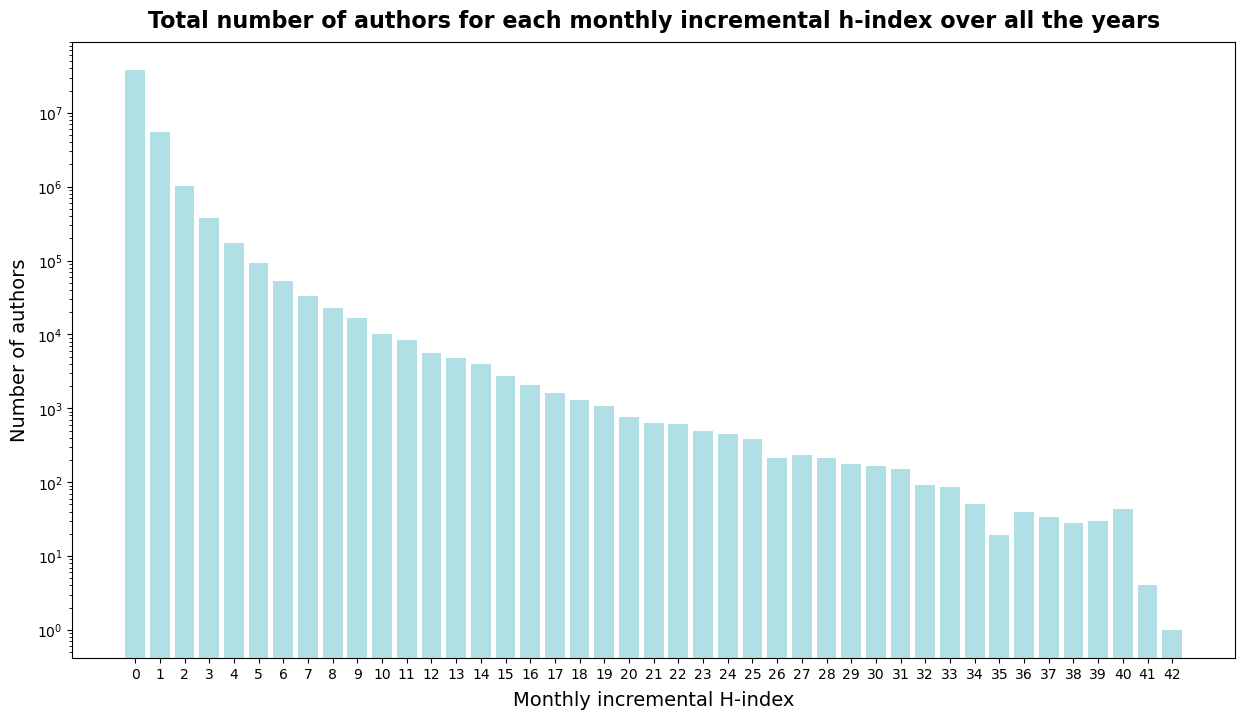

In [14]:
# lables and title specs
label_specs = {"fontsize": 14,"labelpad":6}
title_specs = {"fontsize": 16, "fontweight": "bold", "y": 1.01}

number_authors_byhindex = []
# we count how many times each h-index occurs
for element in listuniquevalues:
    specificlist = [x for x in mylist if x==element]
    number_authors_byhindex.append(len(specificlist))
    
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(8)

# score bar chat
# setting the axes of our horizontal bar plot

plt.bar(listforlabel, number_authors_byhindex, color="powderblue")  
# setting the column of our dataset ('number of papers') that we want to plot as a numerical variable

# setting the labels of our axes
plt.xlabel("Monthly incremental H-index",**label_specs)
plt.ylabel("Number of authors",**label_specs)
plt.yscale('log')

# setting the bar plot title
plt.title("Total number of authors for each monthly incremental h-index over all the years",**title_specs)

# showing the bar plot (command not necessary, but it avoids to print the explanation text)
plt.show()

__Observations__

As expected most of the monthly 'not incremental' h-indices are below 5. The incremental h-indices are significantly above the not incremental h-indices just as expected.

We now analyze these values in pie charts, to see what is the true proportion of monthly h-indices in my dataset.

First I visualize it counting the monthly h-indices that are 0. Second I visualize it counting the monthly h-indices that are not 0. This allows me to see better what are the non-zero monthly h-indices, since most of them were 0.

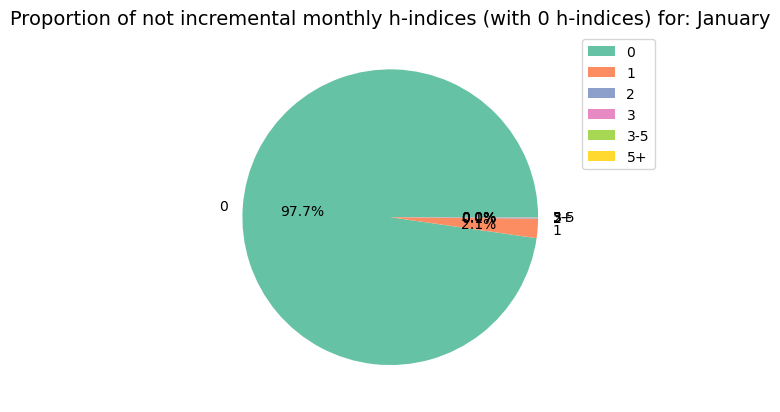

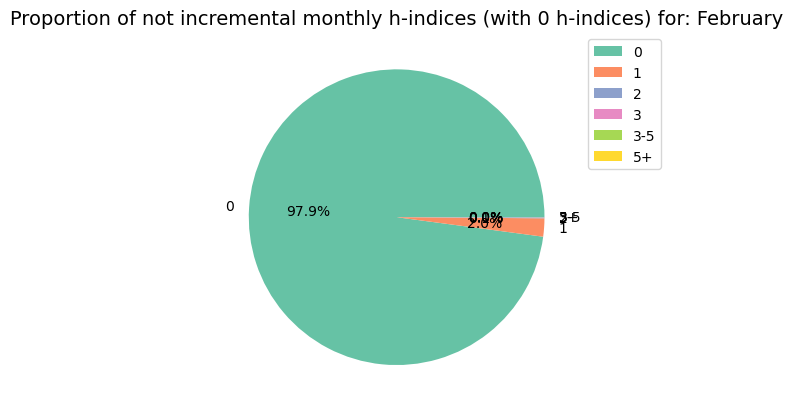

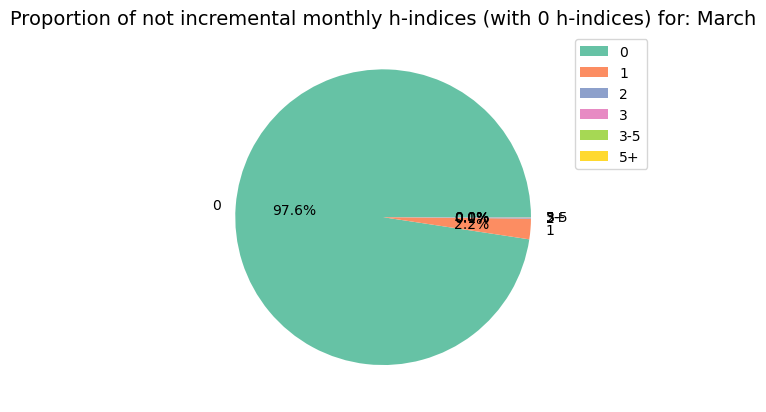

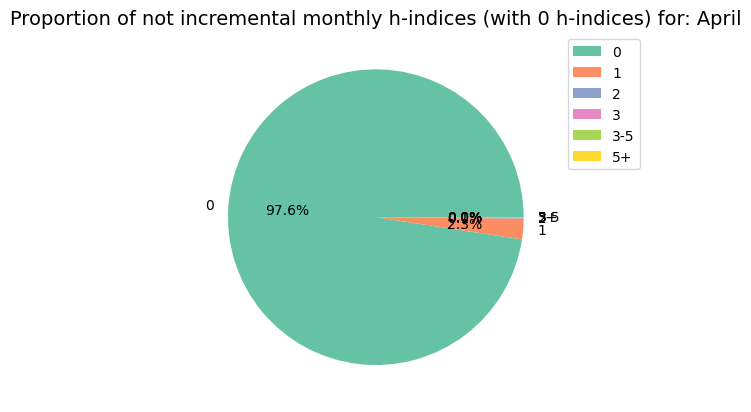

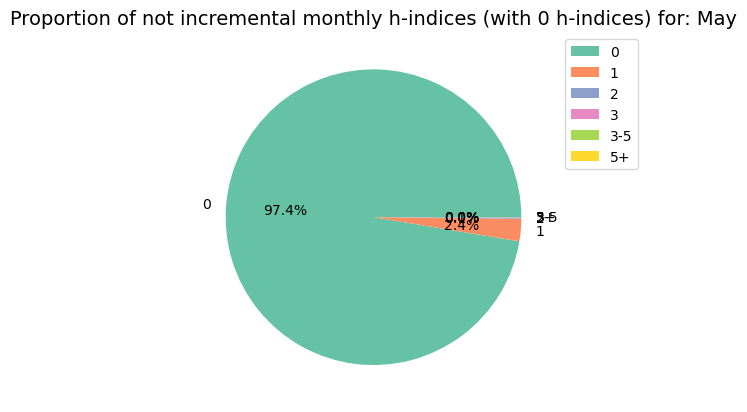

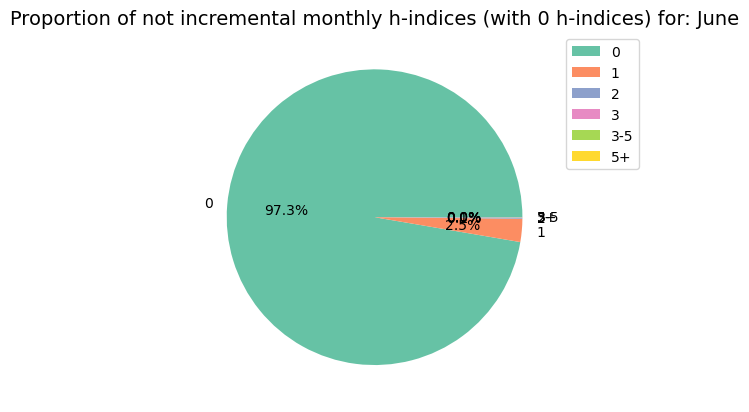

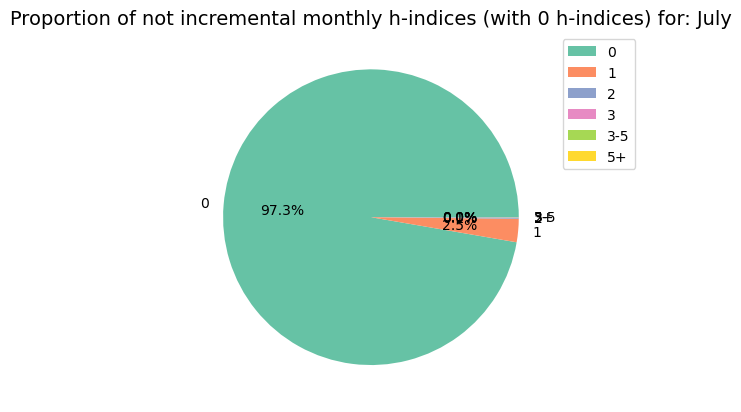

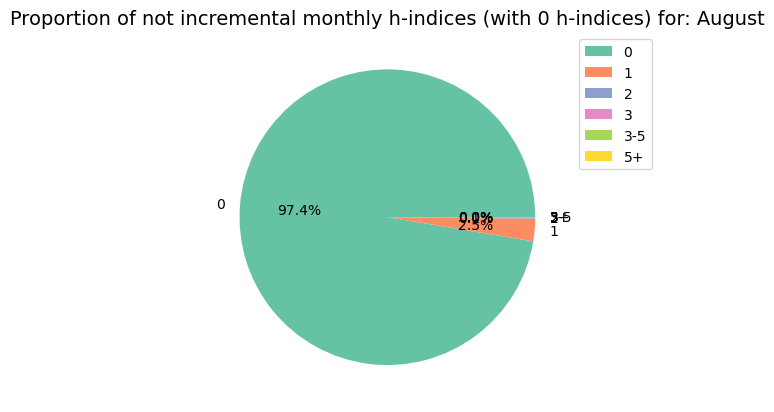

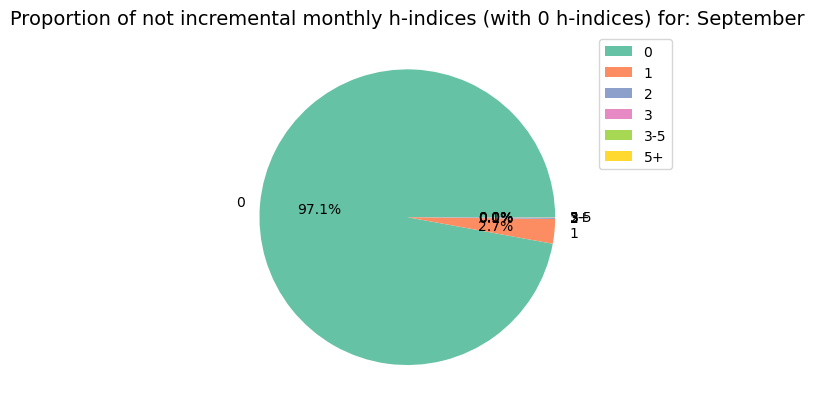

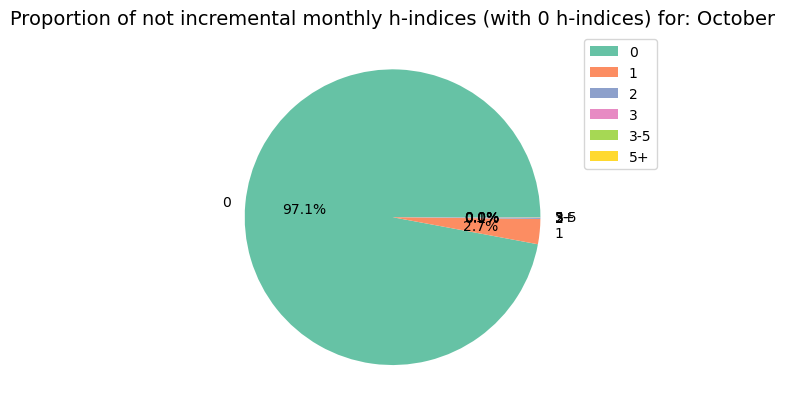

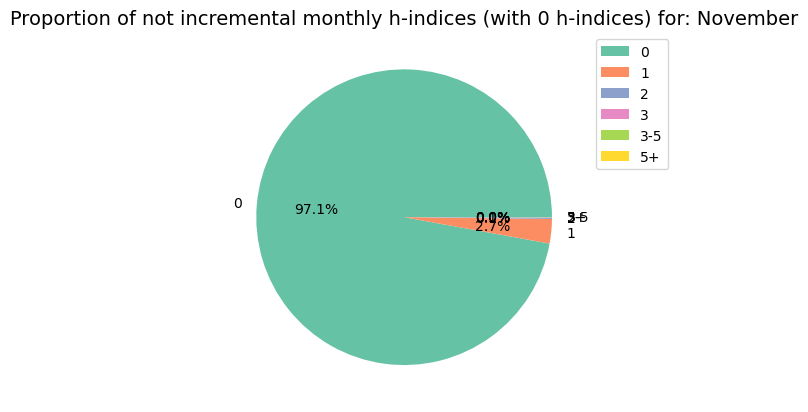

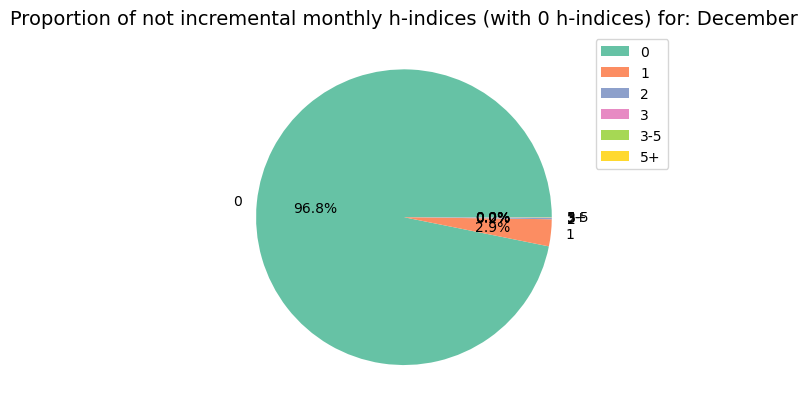

In [15]:
# little fancy visualization for df_hindices

list_indices_int = [0,1,2,3]
list_indices_range = [3,5,2000]

my_months = ['January','February','March','April','May','June','July','August','September','October','November','December']

#just as done previously we visualize for each month the count of h-indices monthly not incremental

for month in my_months:
    df = df_hindices.loc[df_hindices['month']==month].copy()
    h_indices_formonth = df.monthly_H_index_notincremental.tolist()
    numberauthors_hindex = []

    for i in range(4):
        specificlist=[x for x in h_indices_formonth if x==list_indices_int[i]]
        numberauthors_hindex.append(len(specificlist))

    for i in range(2):
        specificlist=[x for x in h_indices_formonth if list_indices_range[i+1]>x>=list_indices_range[i]]
        numberauthors_hindex.append(len(specificlist))
    
    # First pie chart
    # data to be displayed

    # labels for radability and intepretation
    labels1 = ["0","1", "2","3","3-5","5+"]

    # colors
    colors = sns.color_palette("Set2")

    # creating the pie chart
    plt.pie(numberauthors_hindex, labels=labels1, colors=colors, autopct="%0.1f%%")

    # title
    plt.title("Proportion of not incremental monthly h-indices (with 0 h-indices) for: "+str(month),
    color="black",  # I am using the 'white' color here, as I am using the 'dark mode' of Jupyter Lab.
    fontsize=14)

    # legend
    plt.legend(bbox_to_anchor=(1, 1))

    # calling the pie chart
    plt.show()

__Observations__

As expected, most of the monthly h-indices are 0, regardless of the specific month we are considering.

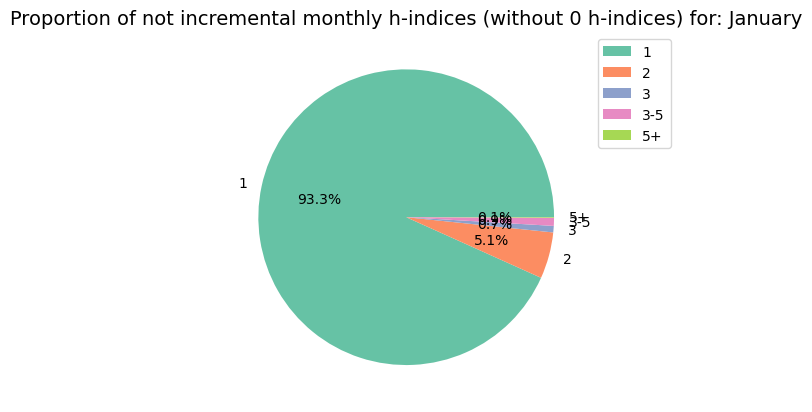

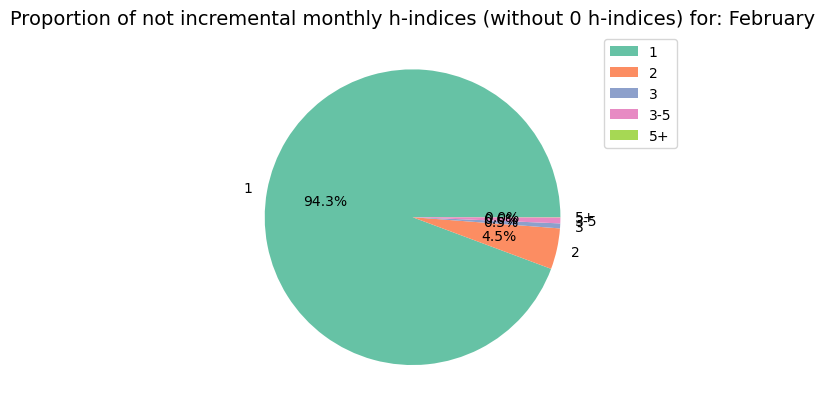

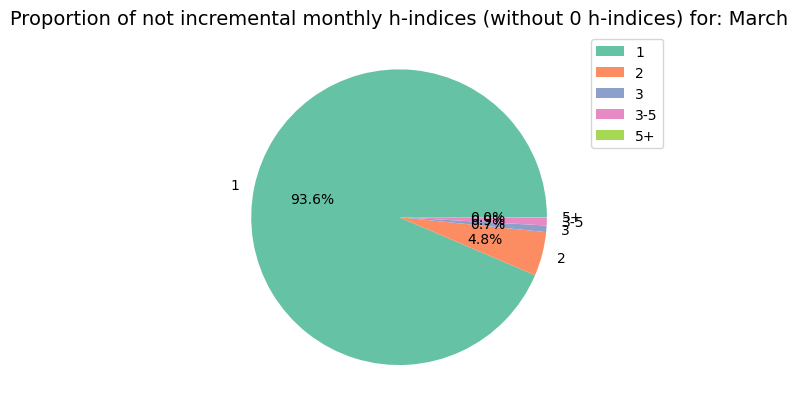

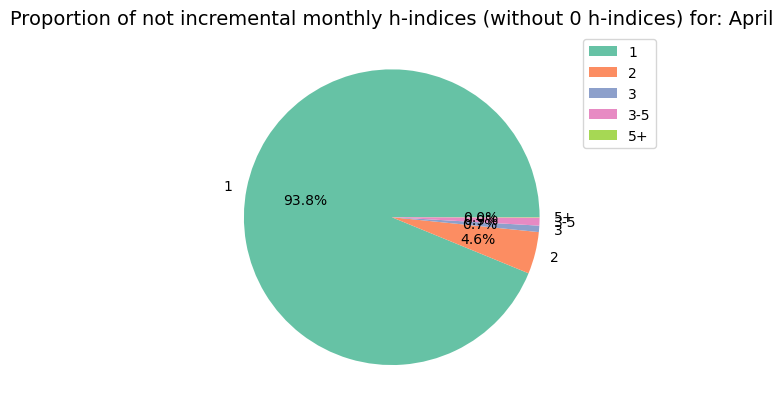

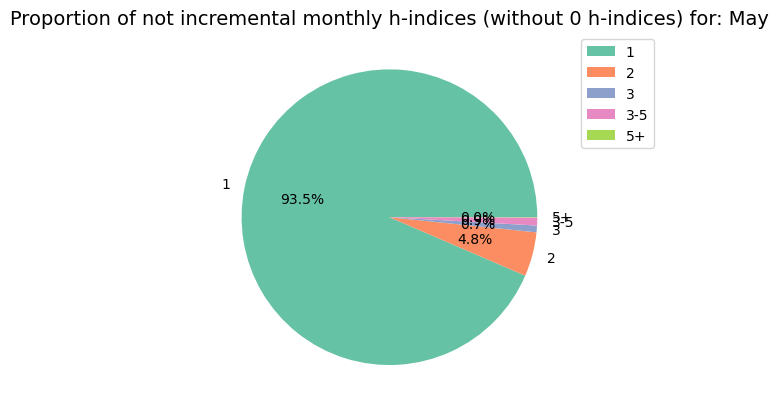

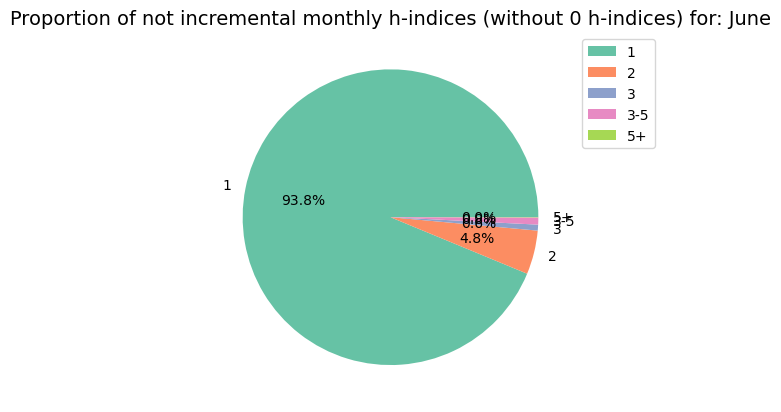

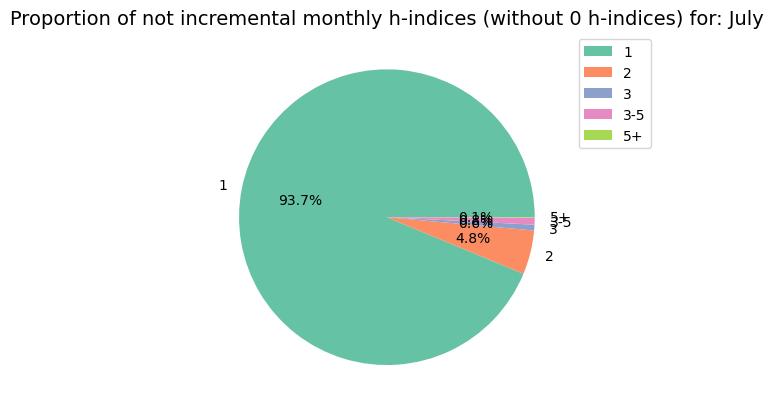

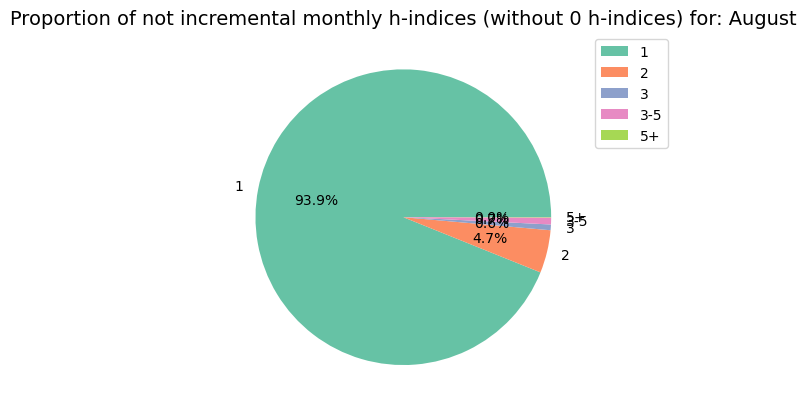

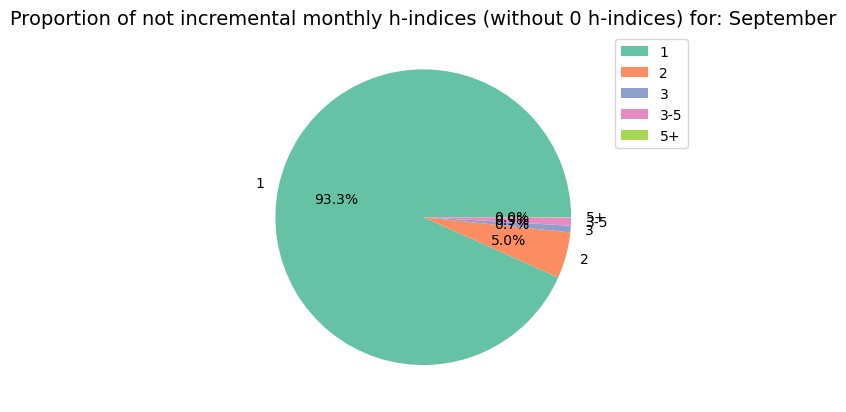

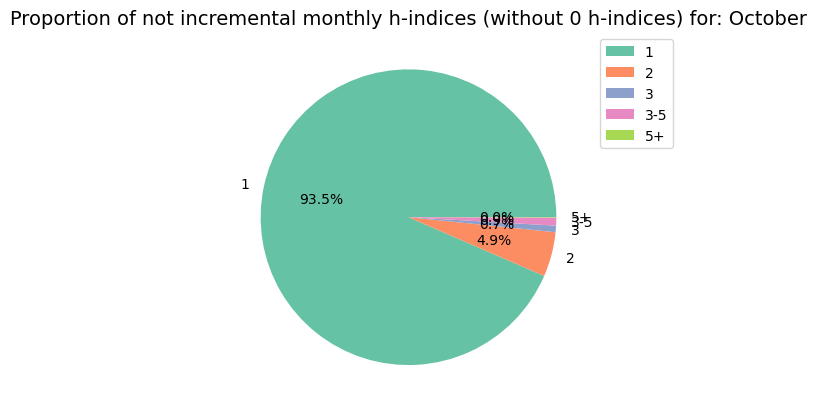

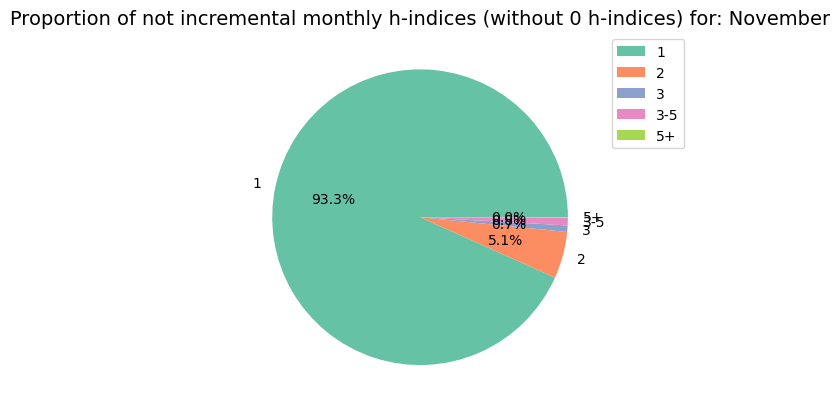

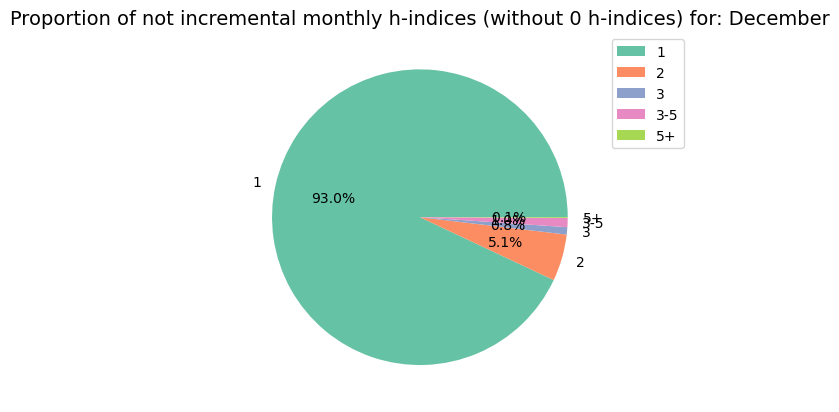

In [16]:
# little fancy visualization for df_hindices

list_indices_int = [1,2,3]
list_indices_range = [3,5,2000]

my_months = ['January','February','March','April','May','June','July','August','September','October','November','December']

# just as done previously we visualize for each month the count 
# of h-indices monthly not incremental (but without the 0 indices this time)

for month in my_months:
    df = df_hindices.loc[df_hindices['month']==month].copy()
    h_indices_formonth = df.monthly_H_index_notincremental.tolist()
    numberauthors_hindex = []

    for i in range(3):
        specificlist=[x for x in h_indices_formonth if x==list_indices_int[i]]
        numberauthors_hindex.append(len(specificlist))

    for i in range(2):
        specificlist=[x for x in h_indices_formonth if list_indices_range[i+1]>x>=list_indices_range[i]]
        numberauthors_hindex.append(len(specificlist))
    
    # First pie chart
    # data to be displayed

    # labels for radability and intepretation
    labels1 = ["1", "2","3","3-5","5+"]

    # colors
    colors = sns.color_palette("Set2")
    numberauthors_hindex = [int(x) for x in numberauthors_hindex]
    # problème avec numberauthors_hindex
    
    # creating the pie chart
    plt.pie(numberauthors_hindex, labels=labels1, colors=colors, autopct="%0.1f%%")

    # title
    plt.title("Proportion of not incremental monthly h-indices (without 0 h-indices) for: "+str(month),
    color="black",  # I am using the 'white' color here, as I am using the 'dark mode' of Jupyter Lab.
    fontsize=14)

    # legend
    plt.legend(bbox_to_anchor=(1, 1))


    # calling the pie chart
    plt.show()

__Observations__

The situation looks pretty much like the one with zero monthly h-indices. Nevertheless, here most of the monthly h-indices are 1, regardless of the specific month we are considering. There are some h-indices that are 2 and then less than 2% of the monthly h-indices are strictly bigger than 2.

__Yearly h-indices__

We now want to understand and visualize the distribution of authors among the differenty yearly h-indices, incremental and not incremental. We first reduce our dataset to the desired information and compute the list we will use to have some insights on the dataset.

In [17]:
dfhindex_year = df_hindices[['author','year','yearly_H_index_incremental','yearly_H_index_notincremental']]
dfhindex_year = dfhindex_year.drop_duplicates()

In [18]:
dfhindex_year

author  year  yearly_H_index_incremental  \
0         https://openalex.org/A2800469661  2002                           0   
12        https://openalex.org/A2800469661  2003                           0   
24        https://openalex.org/A2800469661  2004                           0   
36        https://openalex.org/A2800469661  2005                           0   
48        https://openalex.org/A2800469661  2006                           0   
...                                    ...   ...                         ...   
45427980  https://openalex.org/A2763418023  2018                           1   
45427992  https://openalex.org/A2763418023  2019                           1   
45428004  https://openalex.org/A2763418023  2020                           1   
45428016  https://openalex.org/A2763418023  2021                           2   
45428028  https://openalex.org/A2763418023  2022                           2   

          yearly_H_index_notincremental  
0                                     0  
12                                    0  
24                                    0  
36                                    0  
48                                    0  
...                                 ...  
45427980                              0  
45427992                              1  
45428004                              0  
45428016                              1  
45428028                              1  

[3785670 rows x 4 columns]

I compute a list of lists. For every year, I compute a list, which gives the number of authors for each h-indices grouped in intervall.

In [19]:
my_years = [2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]

list_indices_int = [0,1,2,3]
list_indices_range = [3,5,7,10,15,25,40,2000]

numberauthors_byh_index_incremental_allyears=[]
numberauthors_byh_index_fortheyear_allyears = []

for year in tqdm(my_years):
    
    # we first create the data I will use
    
    numberauthors_byh_index_incremental = []
    numberauthors_byh_index_fortheyear = []
    
    myinfo_year = dfhindex_year.loc[dfhindex_year['year']==year]
    my_h_indices = myinfo_year.yearly_H_index_incremental.tolist() 
    my_h_indices_fortheyear = myinfo_year.yearly_H_index_notincremental.tolist()
    
    # we take all the yearly hindex incremental
    # for each year we have 12 such these h indices that are
    # all the same. So we want to take each h index only once.

    for i in range(4):
        specificlist=[x for x in my_h_indices if x==list_indices_int[i]]
        numberauthors_byh_index_incremental.append(len(specificlist))
        
        specificlist_fortheyear=[x for x in my_h_indices_fortheyear if x==list_indices_int[i]]
        numberauthors_byh_index_fortheyear.append(len(specificlist_fortheyear))
    for i in range(7):
        specificlist=[x for x in my_h_indices if list_indices_range[i+1]>x>=list_indices_range[i]]
        numberauthors_byh_index_incremental.append(len(specificlist))
        specificlist_fortheyear=[x for x in my_h_indices_fortheyear if list_indices_range[i+1]>x>=list_indices_range[i]]
        numberauthors_byh_index_fortheyear.append(len(specificlist_fortheyear))
    
    # we create a list for each year that we append in a list. We will then use it for visualization purposes below.
    numberauthors_byh_index_incremental_allyears.append(numberauthors_byh_index_incremental)
    numberauthors_byh_index_fortheyear_allyears.append(numberauthors_byh_index_fortheyear)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:13<00:00,  1.61it/s]


Now, we visualize my data, which helps me to understand the distribution of yearly and incremental H indices among the authors.

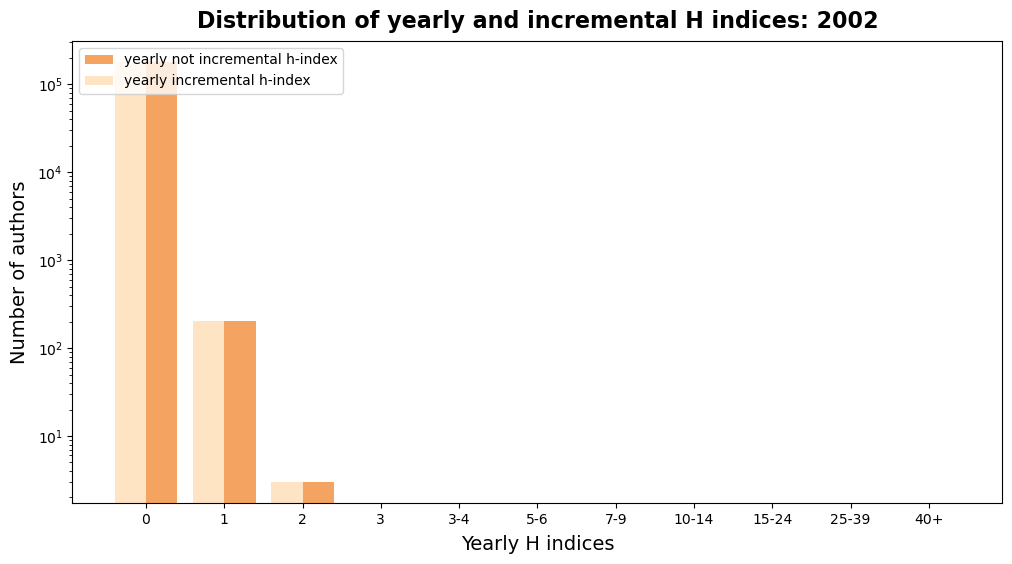

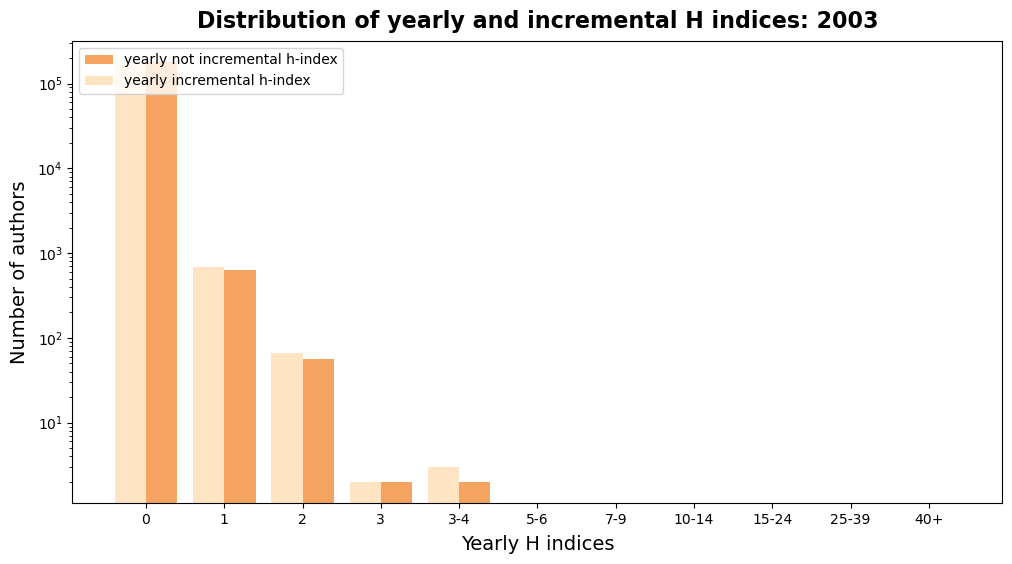

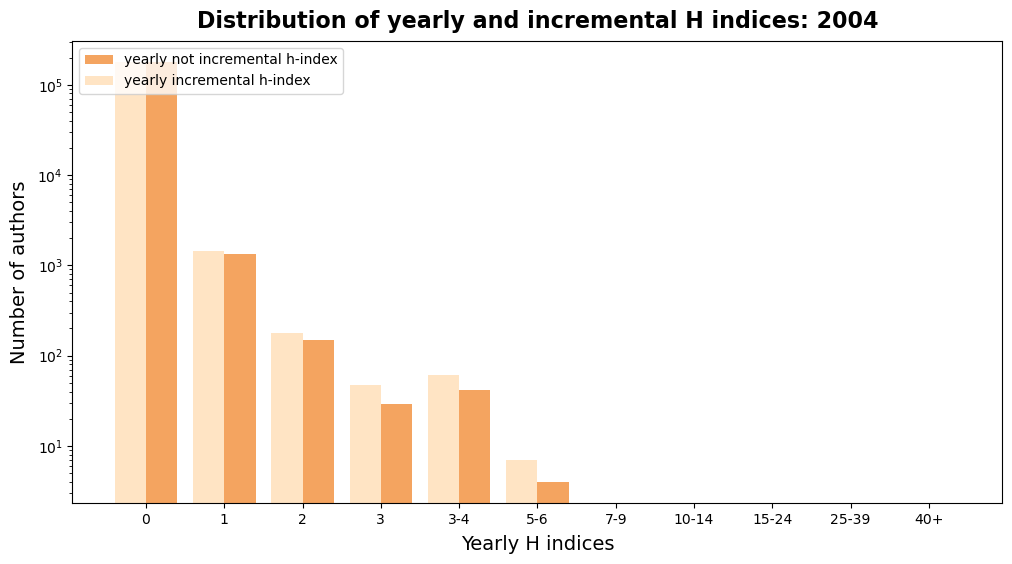

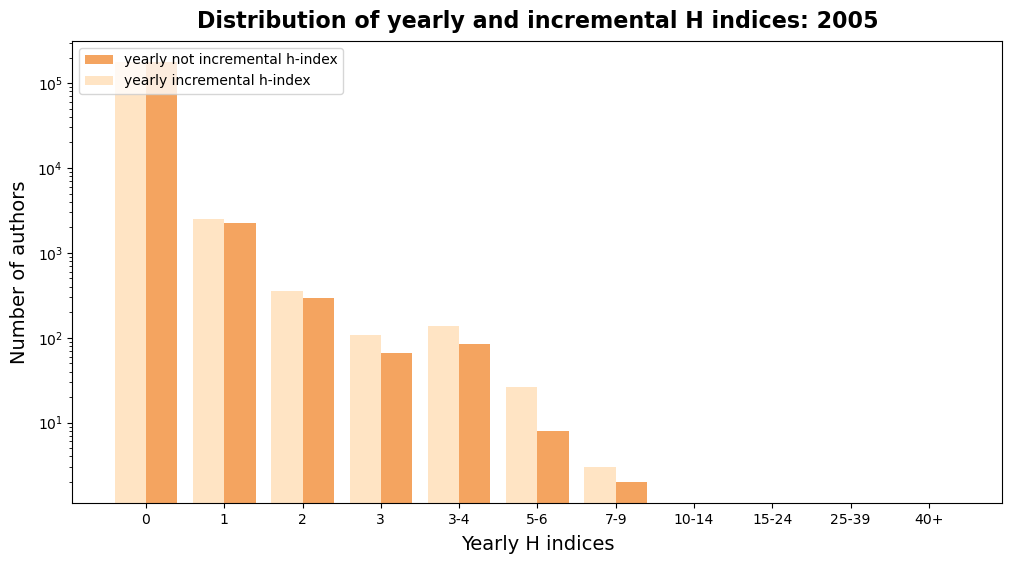

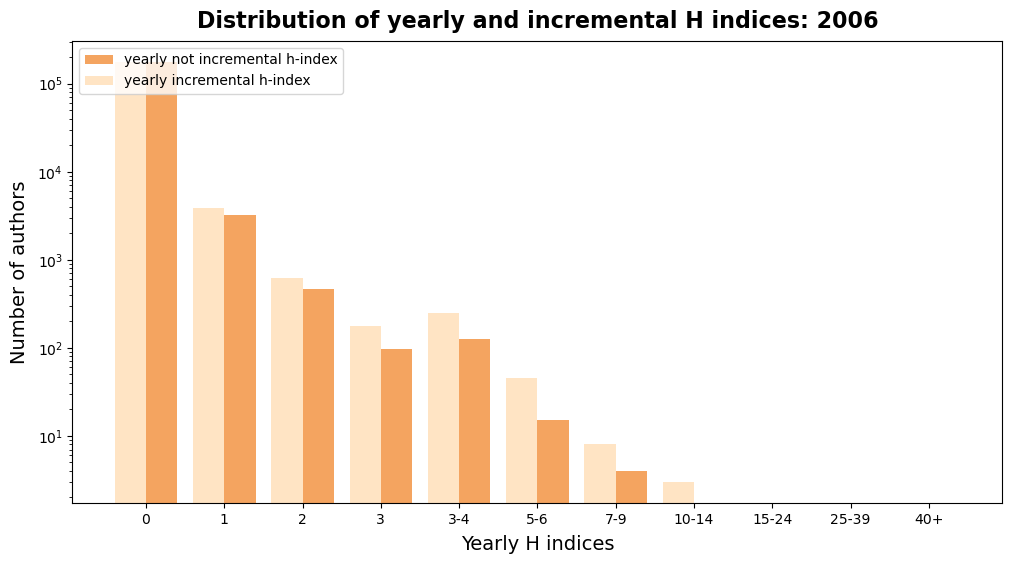

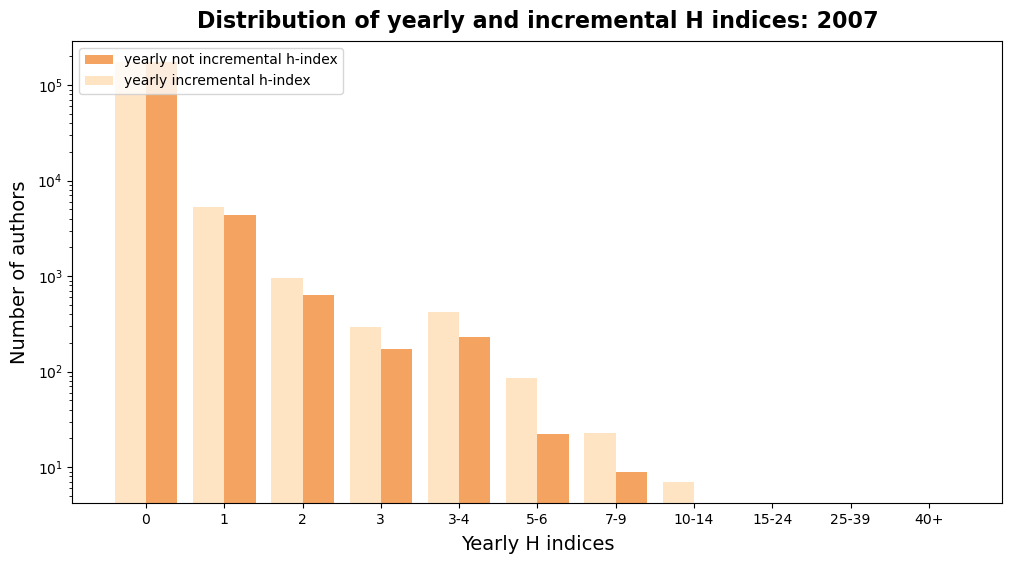

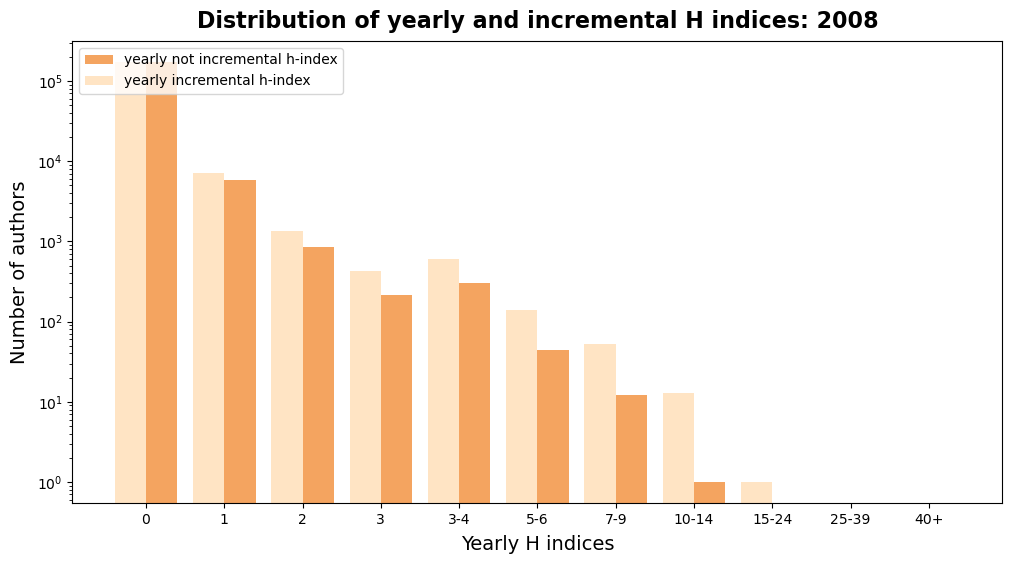

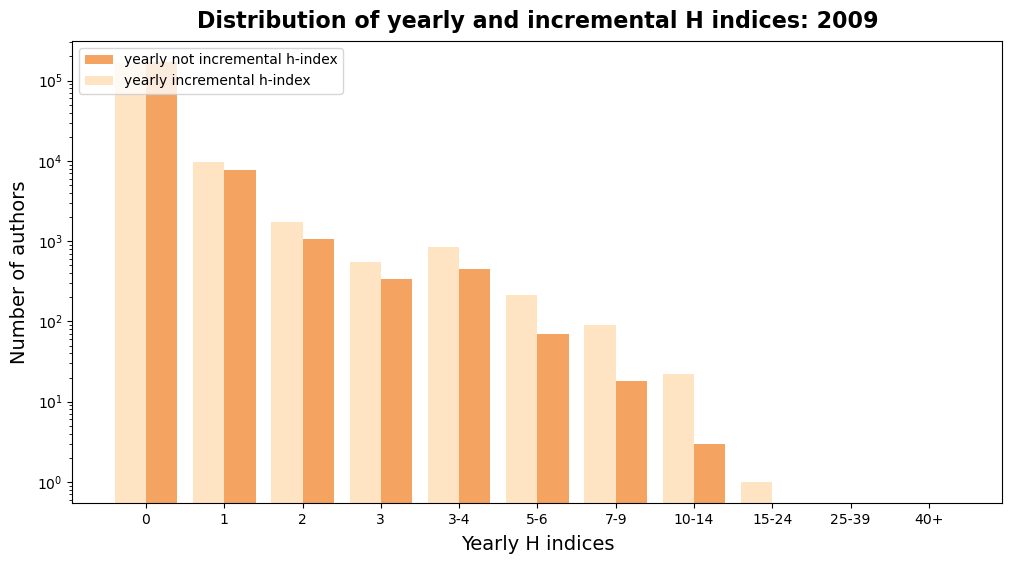

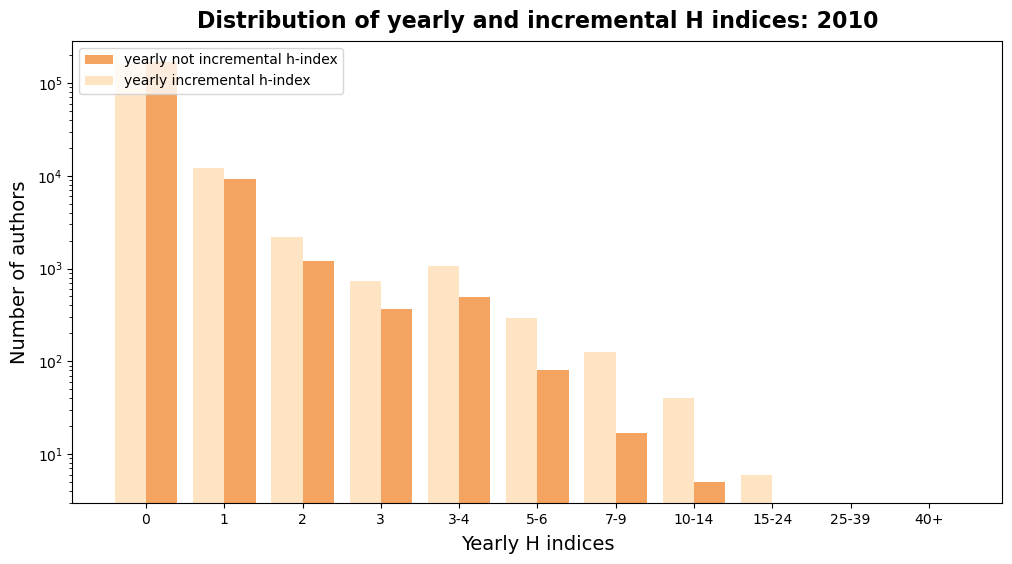

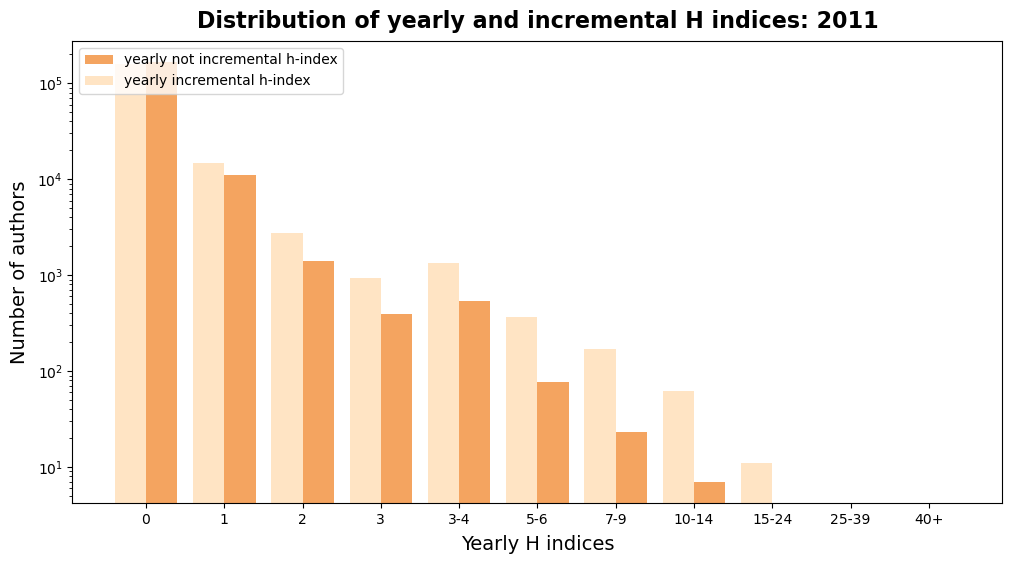

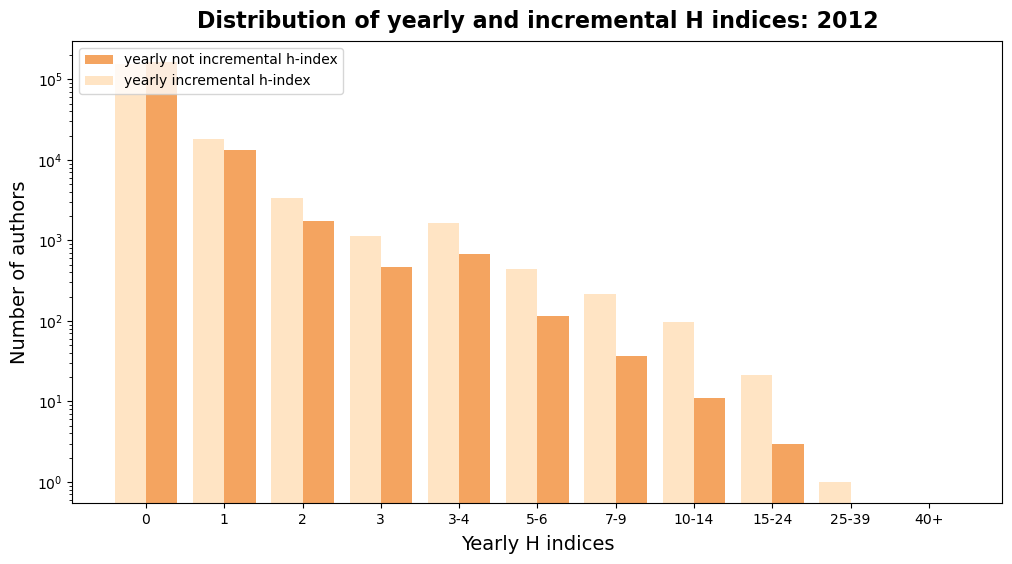

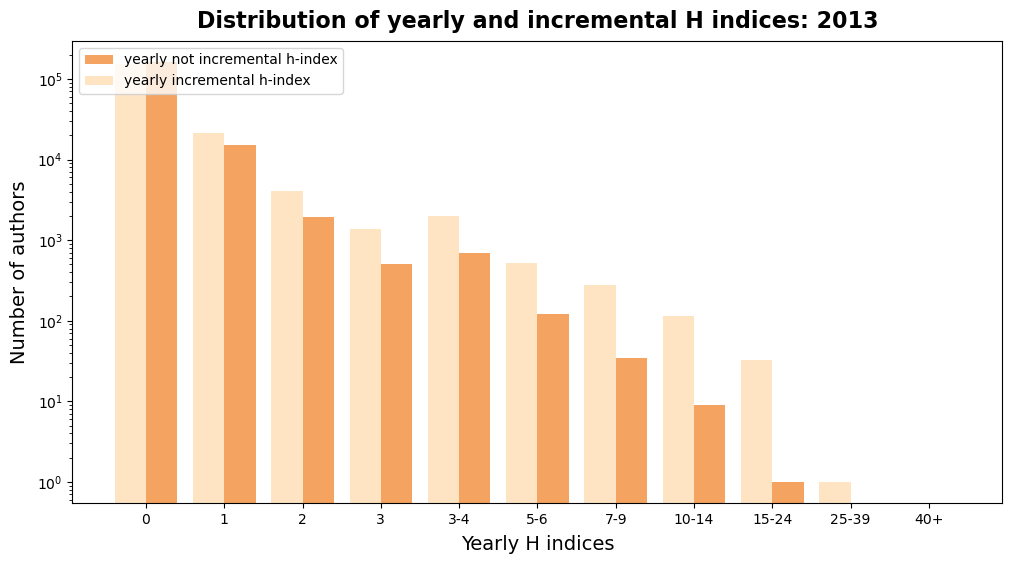

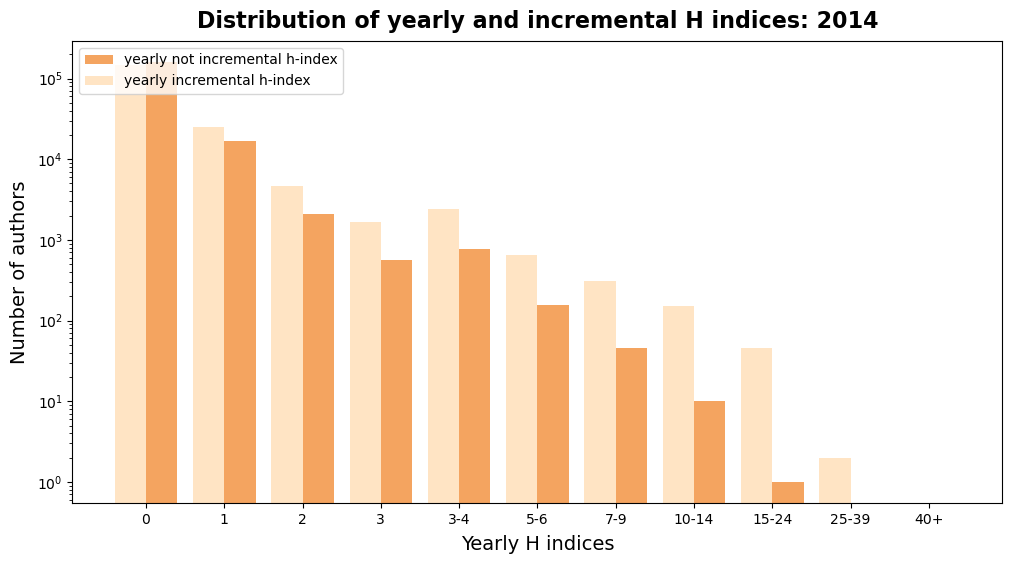

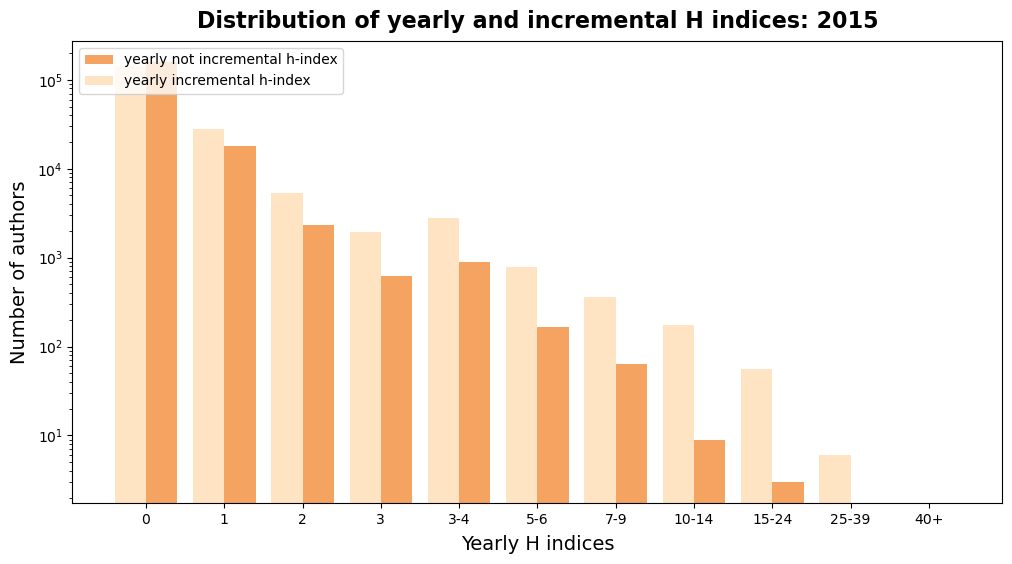

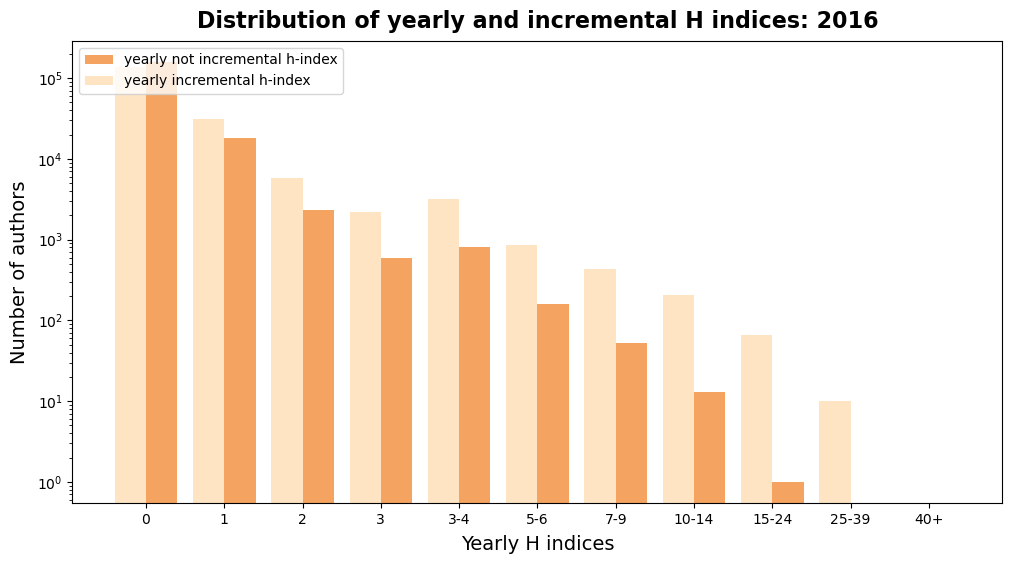

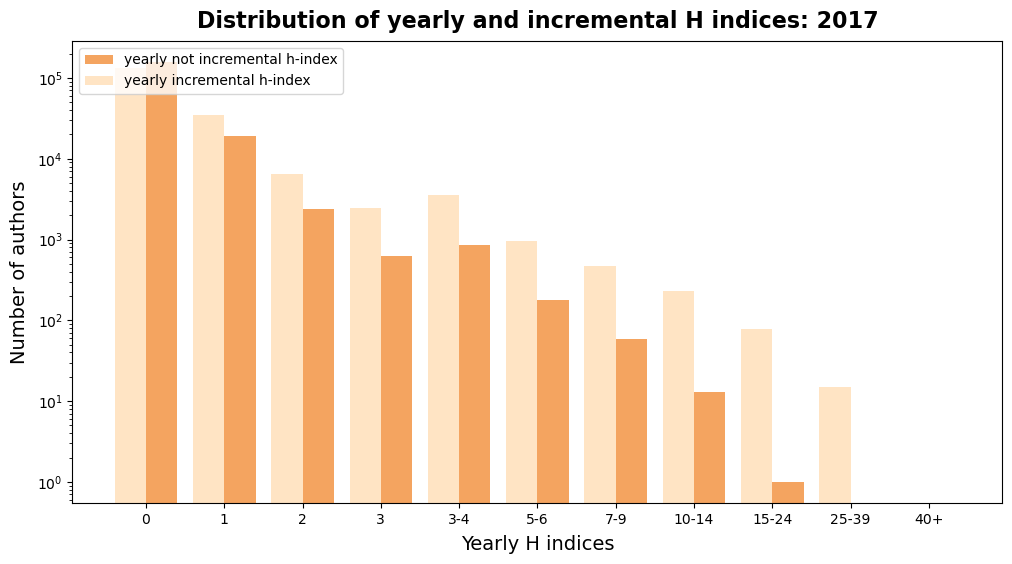

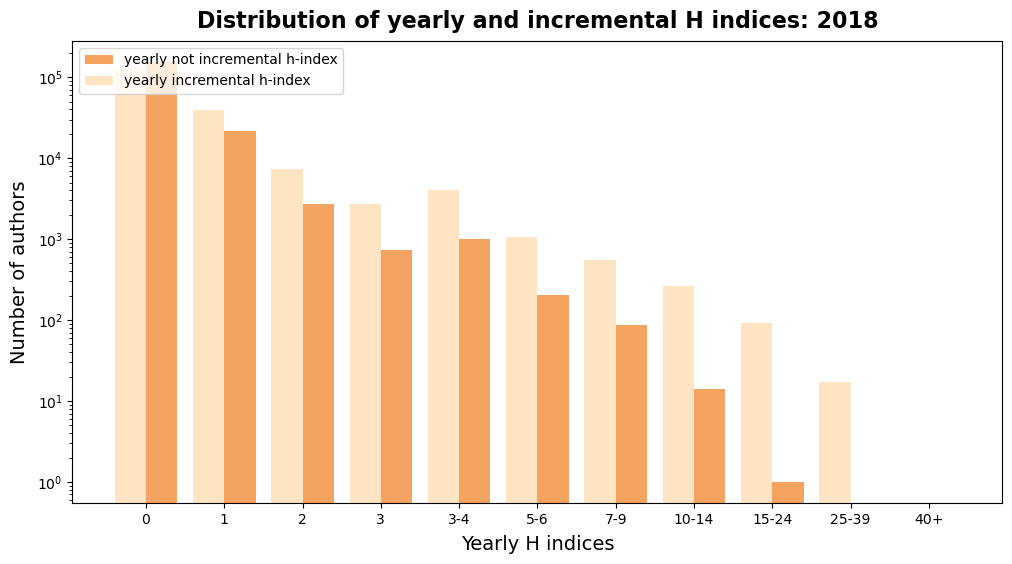

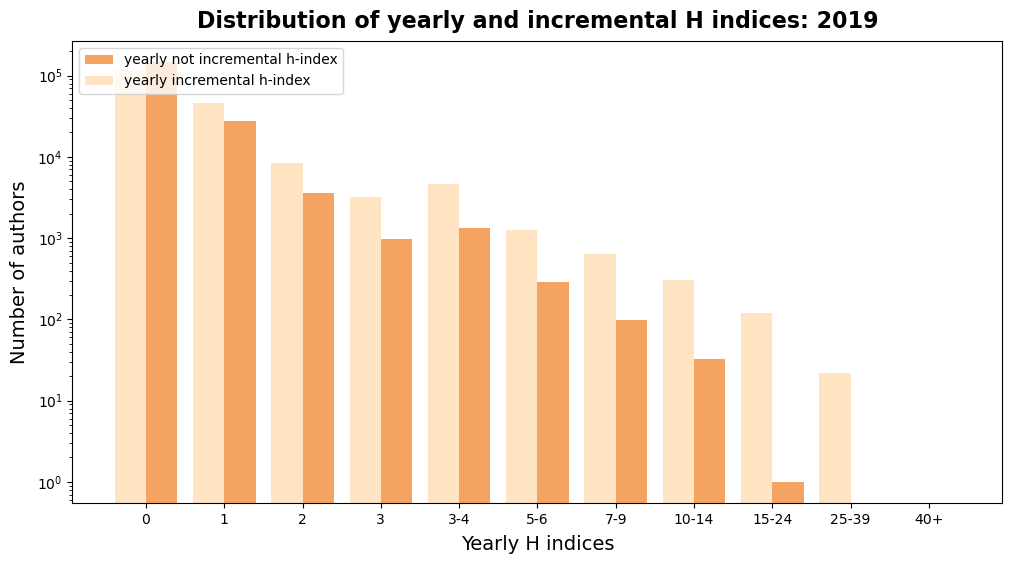

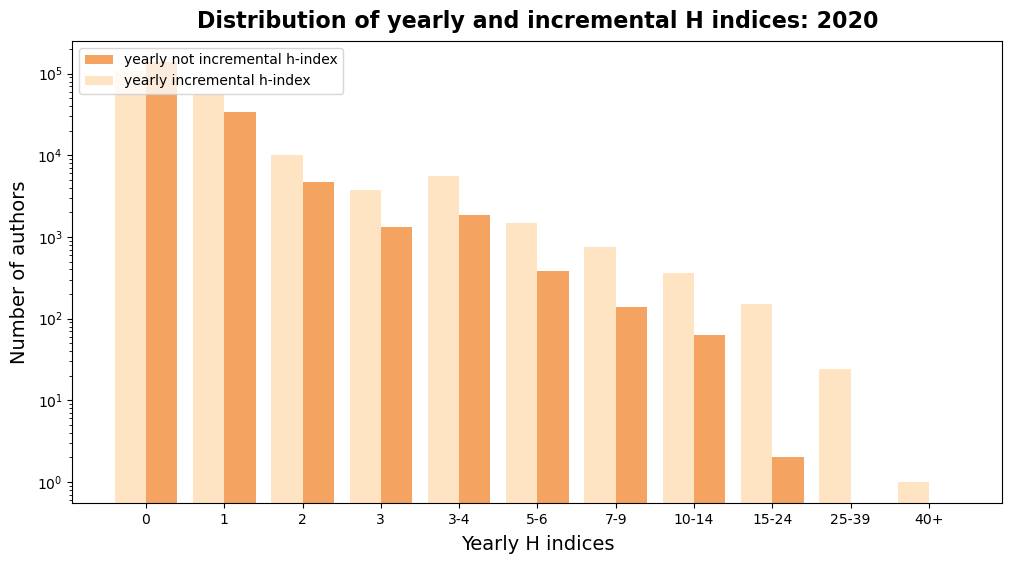

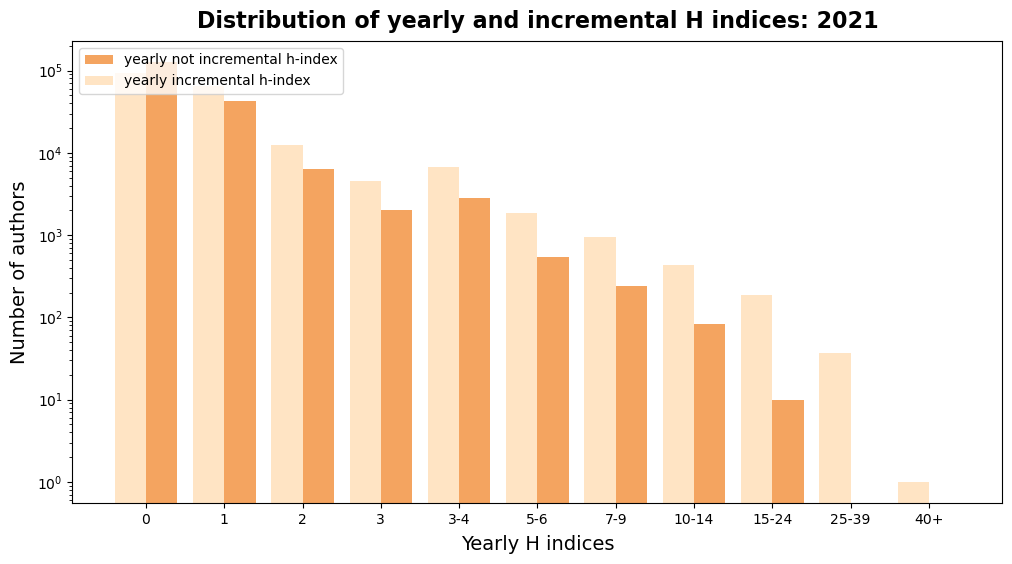

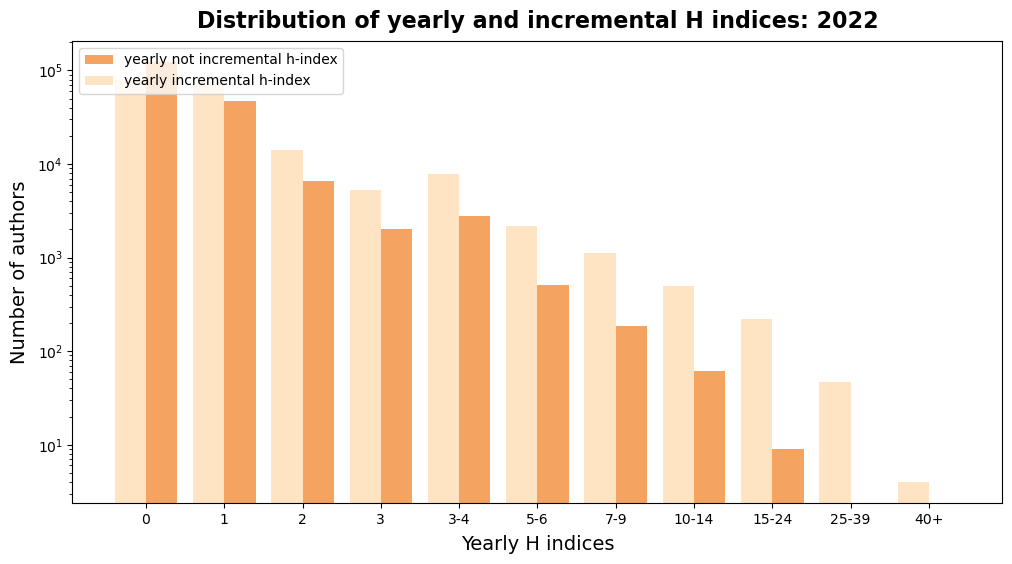

In [20]:
# lables and title specs
label_specs = {"fontsize": 14,"labelpad":6}
title_specs = {"fontsize": 16, "fontweight": "bold", "y": 1.01}

my_years = [2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]


list_indices_int = [0,1,2,3]
list_indices_range = [3,5,7,10,15,25,40,2000]

for year in my_years:

    width = 0.4 
    first_label = 'H-index for the year'
    first_bar_color = 'sandybrown'
    second_label = 'Yearly incremental H-index'
    second_bar_color = 'bisque'
    
    label = ['yearly not incremental h-index','yearly incremental h-index']
    
    
    index=my_years.index(year)
    
    fig = plt.subplots(figsize=(12,6))
    
    
    x_cor = np.arange(0,11,1)
    plt.bar(x_cor + width/2, numberauthors_byh_index_fortheyear_allyears[index], width, label=first_label, color=first_bar_color)
    plt.bar(x_cor - width/2, numberauthors_byh_index_incremental_allyears[index], width, label=second_label, color=second_bar_color) 


    # setting the axes of our horizontal bar plot
    x_label = ['0','1','2','3','3-4','5-6','7-9','10-14','15-24','25-39','40+'] 
    
    
    # setting the labels of our axes
    plt.xlabel("Yearly H indices",**label_specs)
    plt.ylabel("Number of authors",**label_specs)
    plt.yscale('log')
    
    plt.legend(label,loc=2)

    # setting how we want our label ticks
    plt.xticks(x_cor, x_label)

    # setting the bar plot title
    plt.title("Distribution of yearly and incremental H indices: "+str(year),**title_specs)

    # showing the bar plot (command not necessary, but it avoids to print the explanation text)
    plt.show()

__Observations__

Clearly ```yearly_H_index_incremental``` and ```yearly_H_index_notincremental``` are very connected especially at the beginning, when only few years were calculated for the incremental variable. Then after some time, we see that the incremental variable are higher than the others. Besides, most of the yearly 'not-incremental' h-indices are below 5 (since this is in log-scale).

<div class="alert-info">
7. Correlation analysis
</div>

In [21]:
df_hindices

author  year      month  \
0         https://openalex.org/A2800469661  2002    January   
1         https://openalex.org/A2800469661  2002   February   
2         https://openalex.org/A2800469661  2002      March   
3         https://openalex.org/A2800469661  2002      April   
4         https://openalex.org/A2800469661  2002        May   
...                                    ...   ...        ...   
45428035  https://openalex.org/A2763418023  2022     August   
45428036  https://openalex.org/A2763418023  2022  September   
45428037  https://openalex.org/A2763418023  2022    October   
45428038  https://openalex.org/A2763418023  2022   November   
45428039  https://openalex.org/A2763418023  2022   December   

          yearly_H_index_notincremental  yearly_H_index_incremental  \
0                                     0                           0   
1                                     0                           0   
2                                     0                           0   
3                                     0                           0   
4                                     0                           0   
...                                 ...                         ...   
45428035                              1                           2   
45428036                              1                           2   
45428037                              1                           2   
45428038                              1                           2   
45428039                              1                           2   

          monthly_H_index_incremental  monthly_H_index_notincremental  
0                                   0                               0  
1                                   0                               0  
2                                   0                               0  
3                                   0                               0  
4                                   0                               0  
...                               ...                             ...  
45428035                            2                               0  
45428036                            2                               0  
45428037                            2                               1  
45428038                            2                               0  
45428039                            2                               0  

[45428040 rows x 7 columns]

We first change the datatype of some variable.

In [22]:
from pandas.api.types import CategoricalDtype

my_months = ['January','February','March','April','May','June','July','August','September','October','November','December']

cat_dtype = CategoricalDtype(
    categories=my_months, ordered=True)
df_hindices['month']=df_hindices['month'].astype(cat_dtype)

In [23]:
df_hindices['year']=df_hindices['year'].astype(int)

In [24]:
df_hindices.dtypes

author                              object
year                                 int32
month                             category
yearly_H_index_notincremental        int64
yearly_H_index_incremental           int64
monthly_H_index_incremental          int64
monthly_H_index_notincremental       int64
dtype: object

Naturally, we can not consider the variable ```author``` like a category or like a numerical variable. For this reason, we only consider the other variables in our correlation analysis.

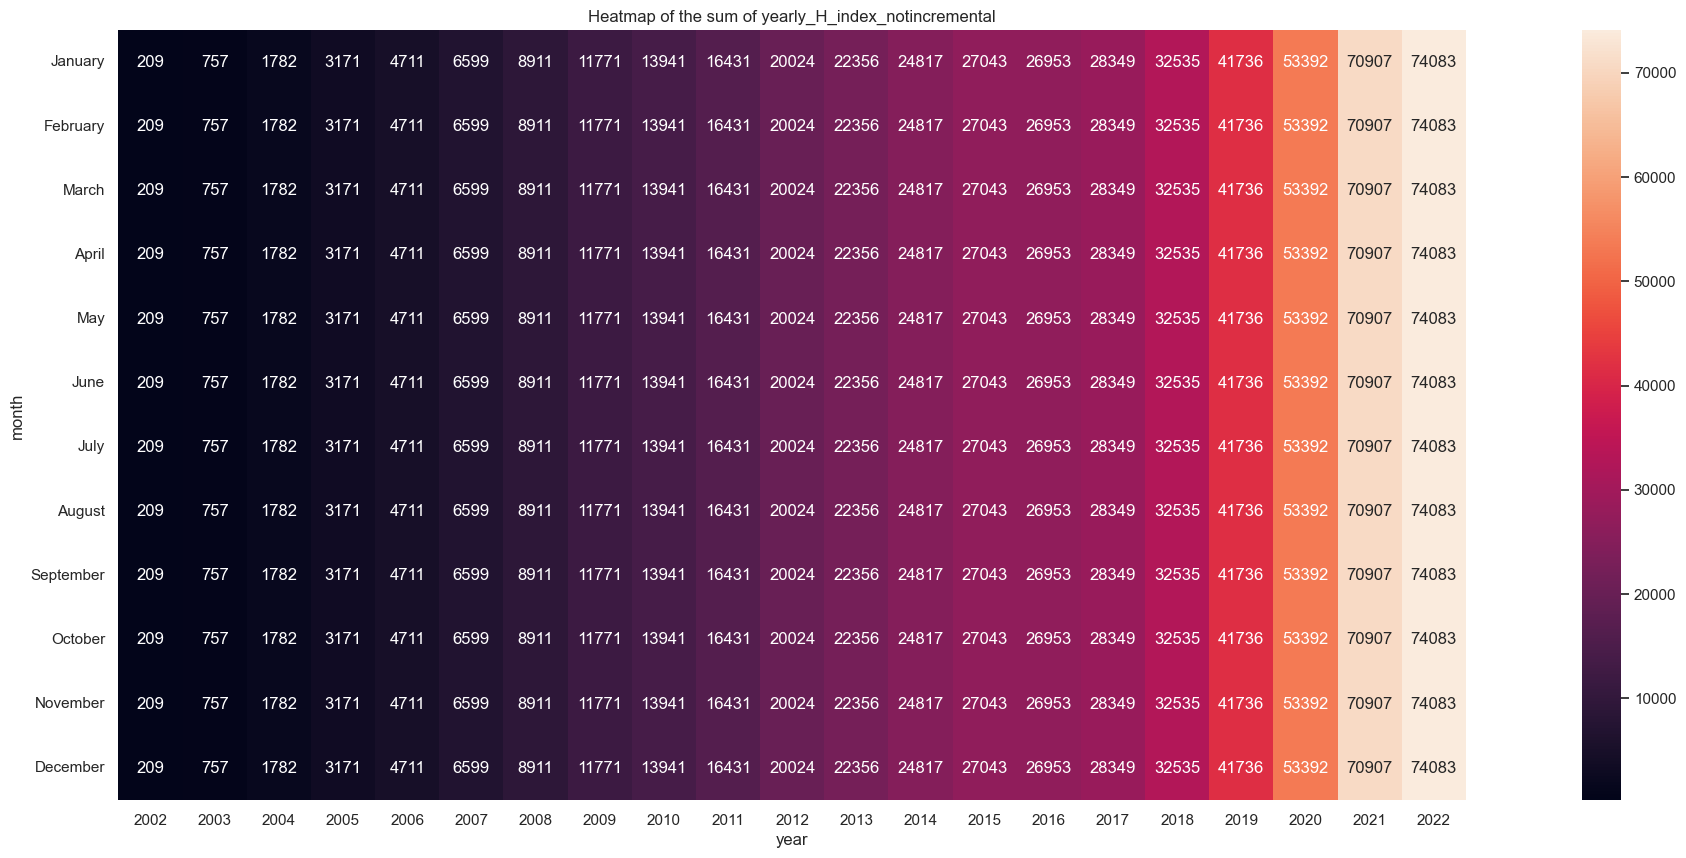

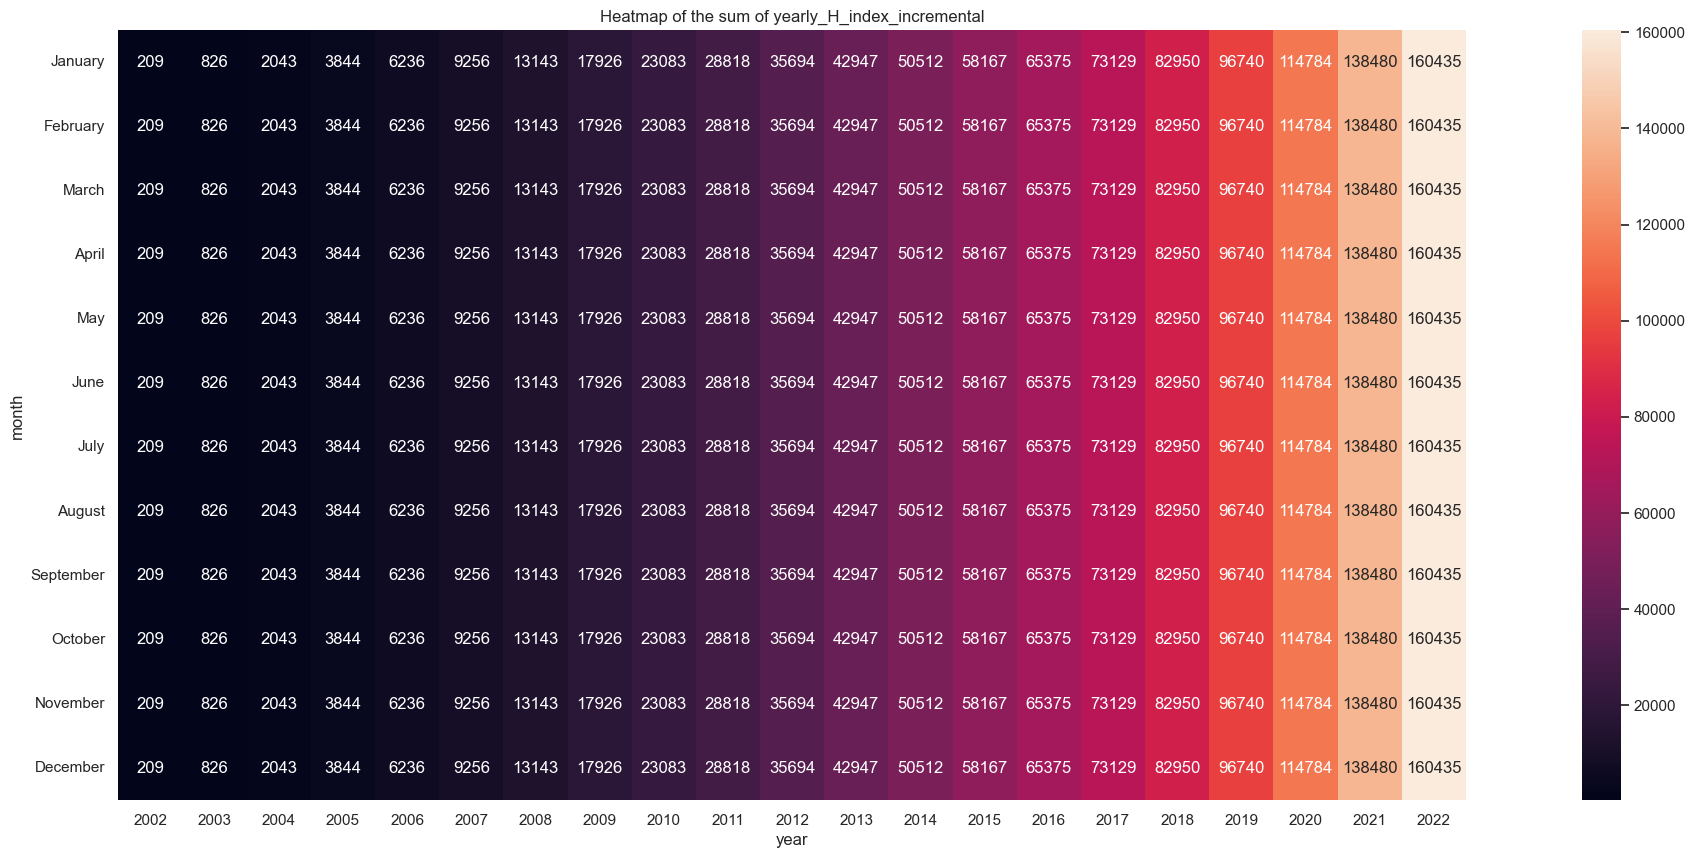

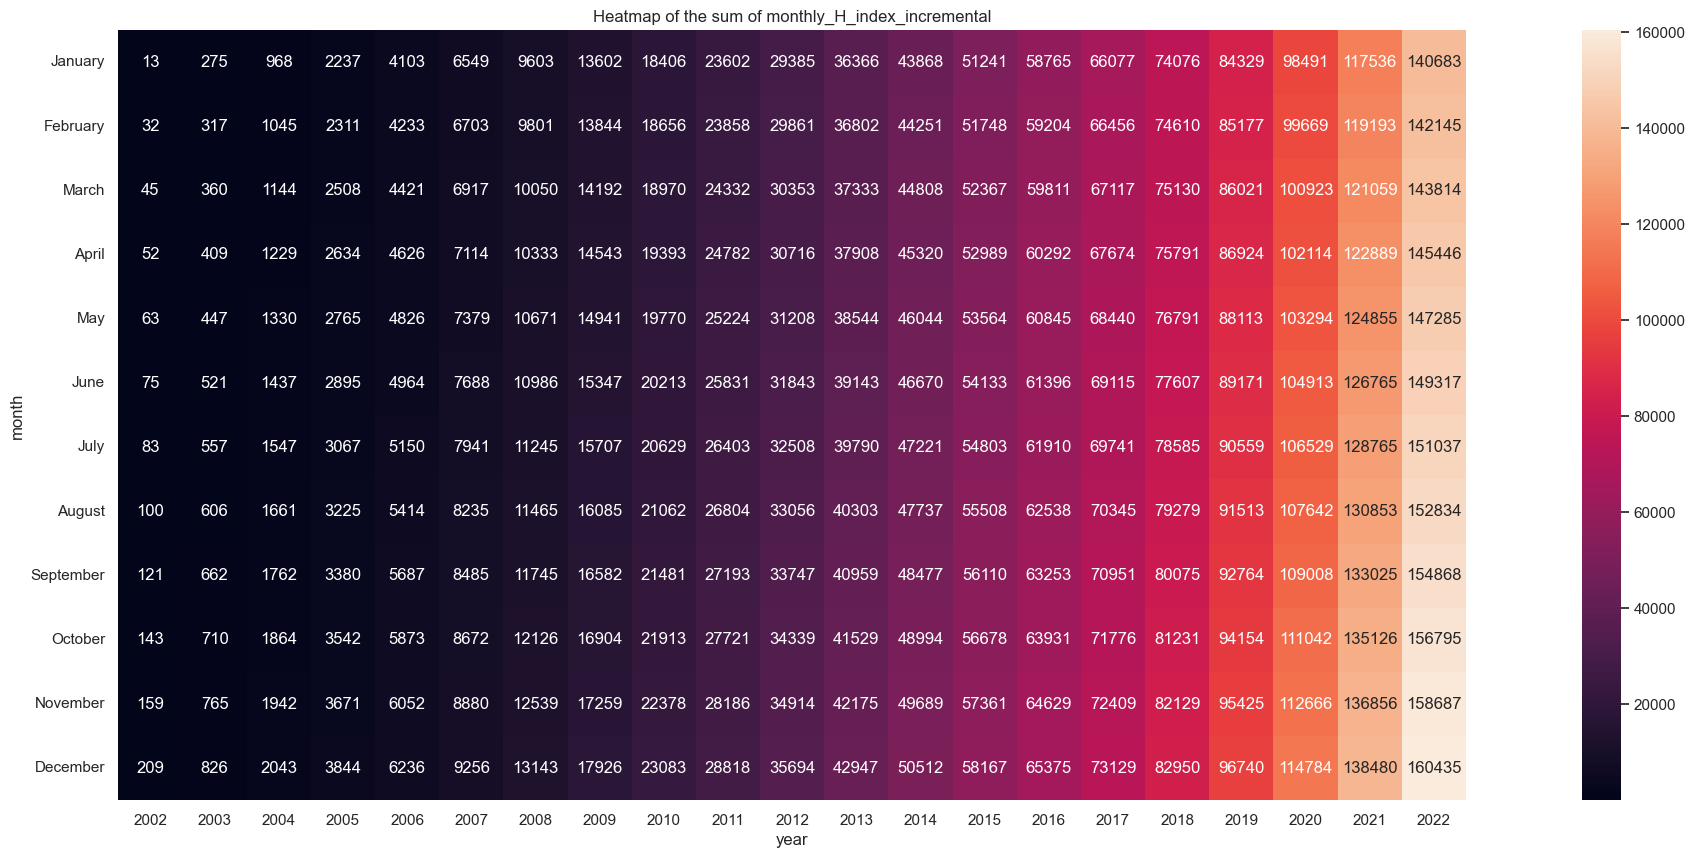

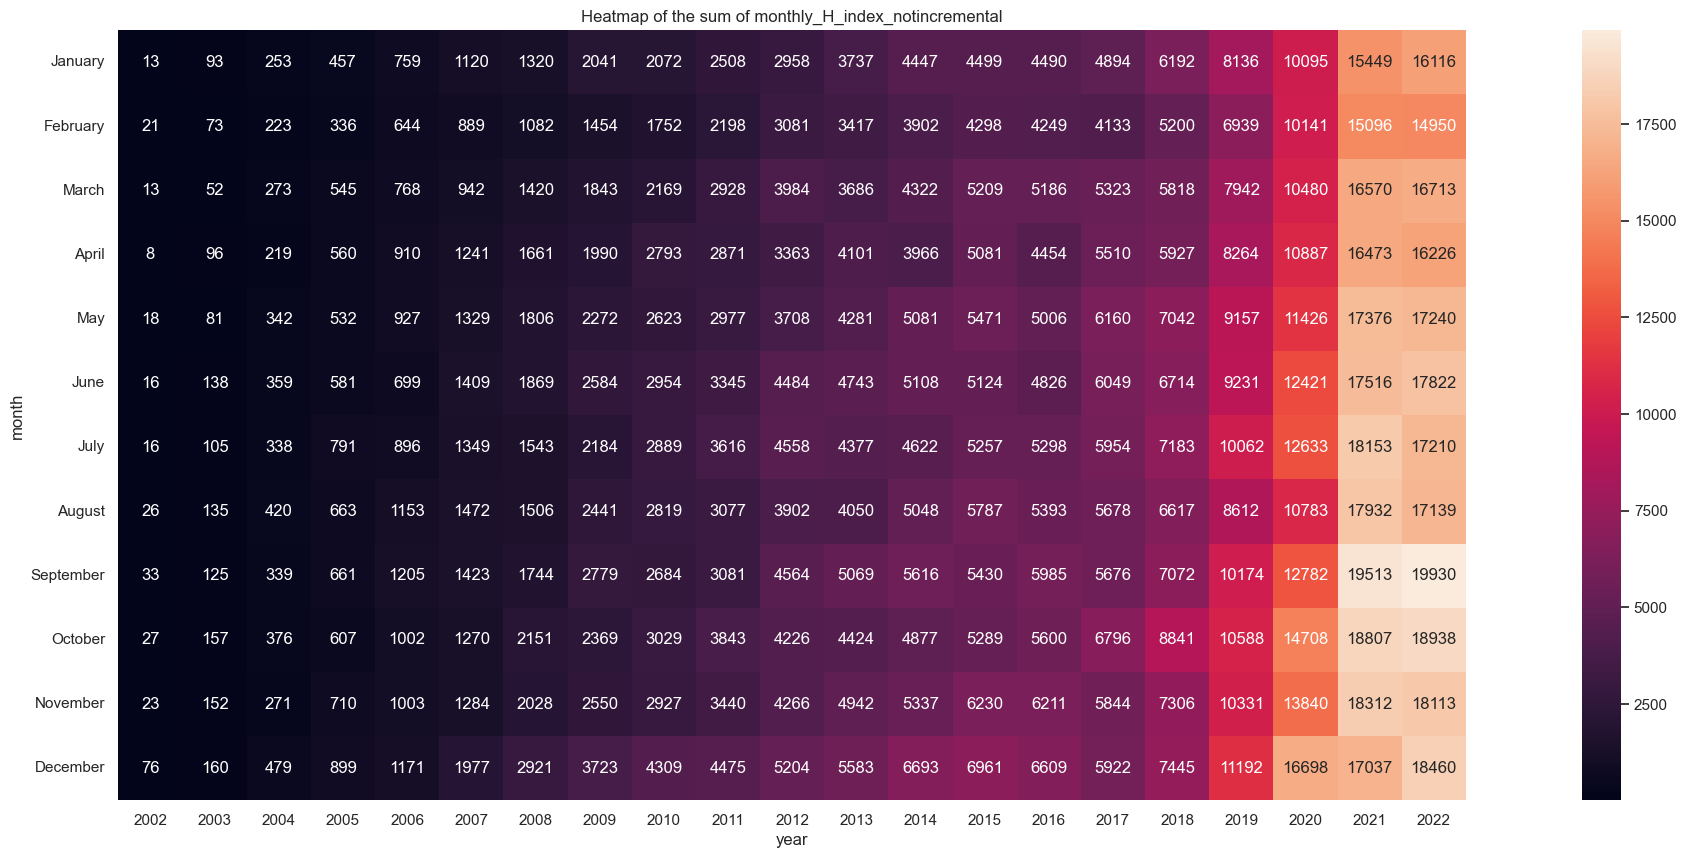

In [25]:
for column in ['yearly_H_index_notincremental','yearly_H_index_incremental','monthly_H_index_incremental','monthly_H_index_notincremental']:
    heatmap_data = pd.pivot_table(
    df_hindices, values=column, index="month", columns="year", aggfunc=np.sum
    )

    sns.set(rc={"figure.figsize": (30, 10)})
    sns.heatmap(heatmap_data, annot=True, square=True, fmt=".0f").set(
    title="Heatmap of the sum of "+str(column)
    )
    plt.show()

__Observations__

Just as planned, there is an increase of the h-indices with time over the years, since there are more citations and a higher interconnectivity within the field of encryption technologies.

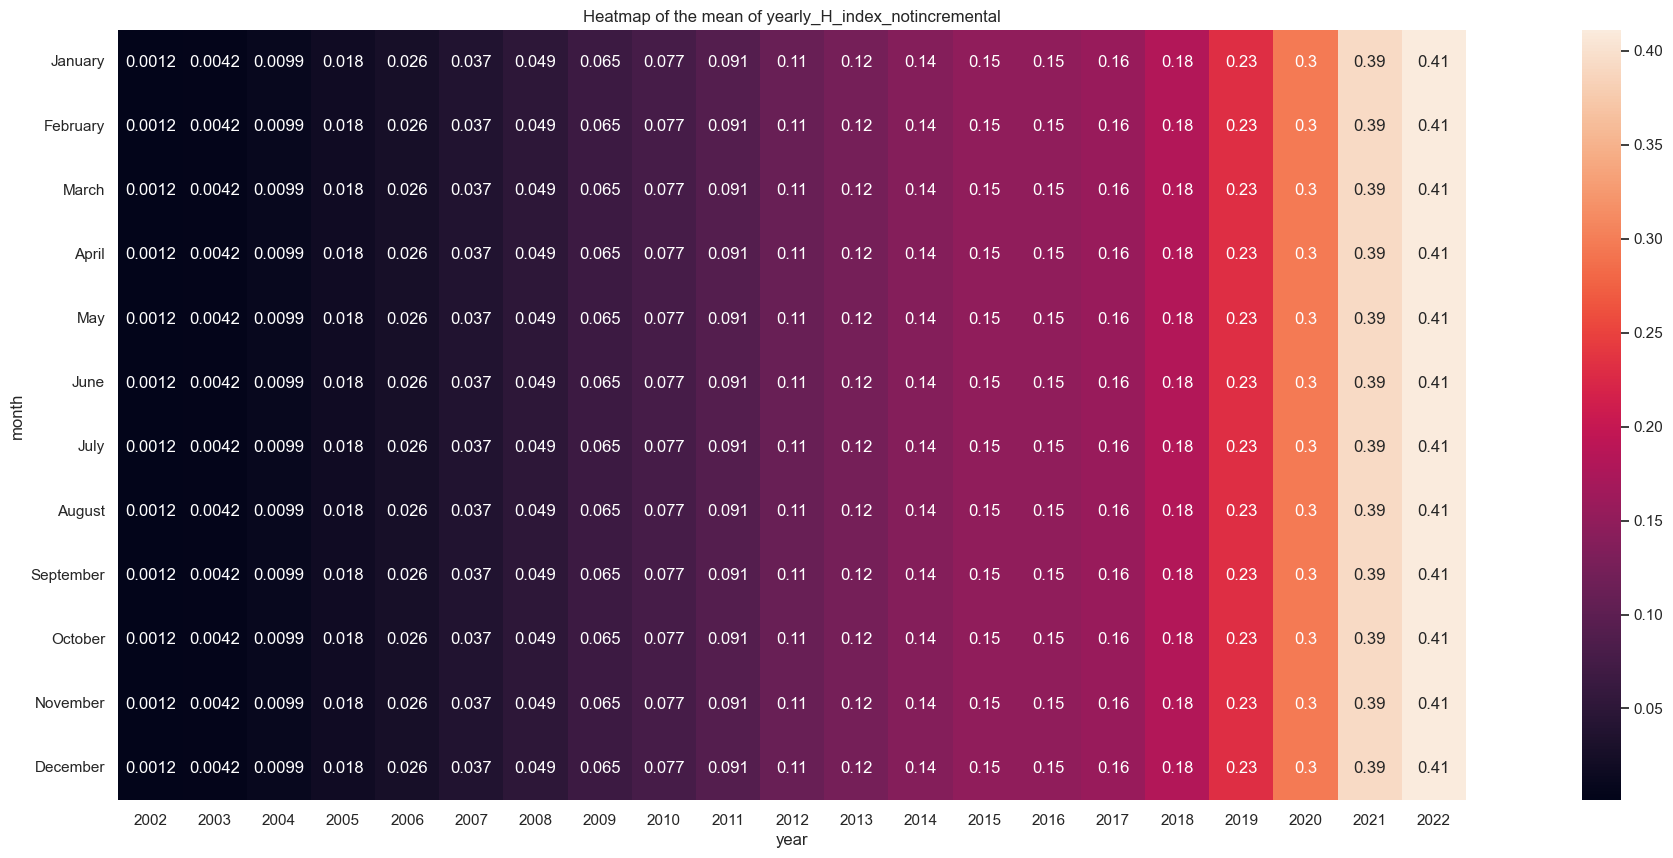

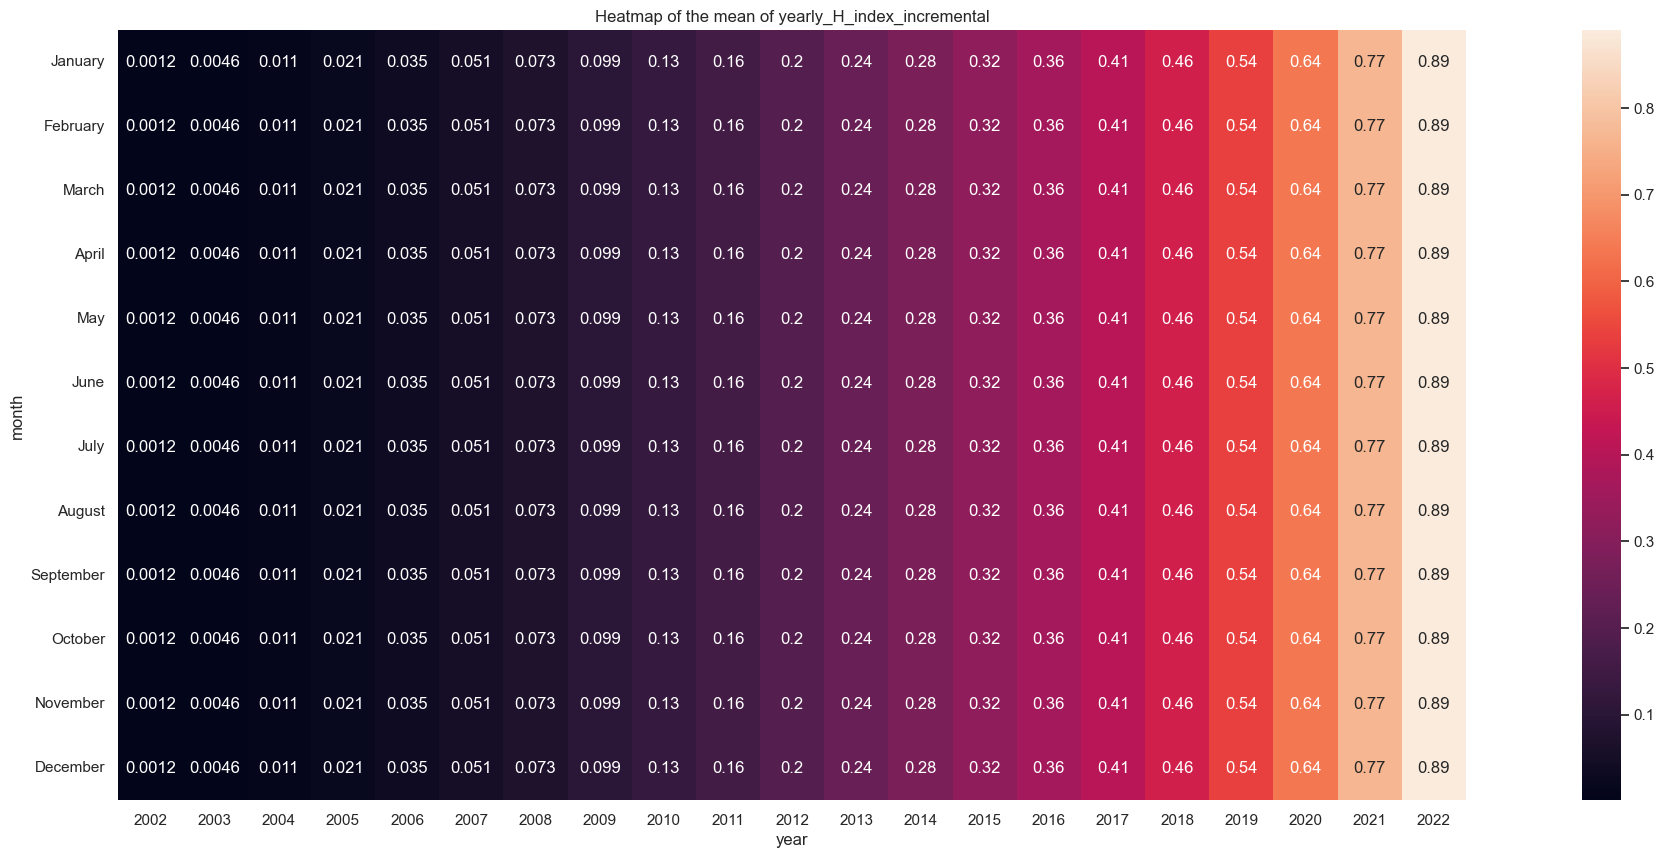

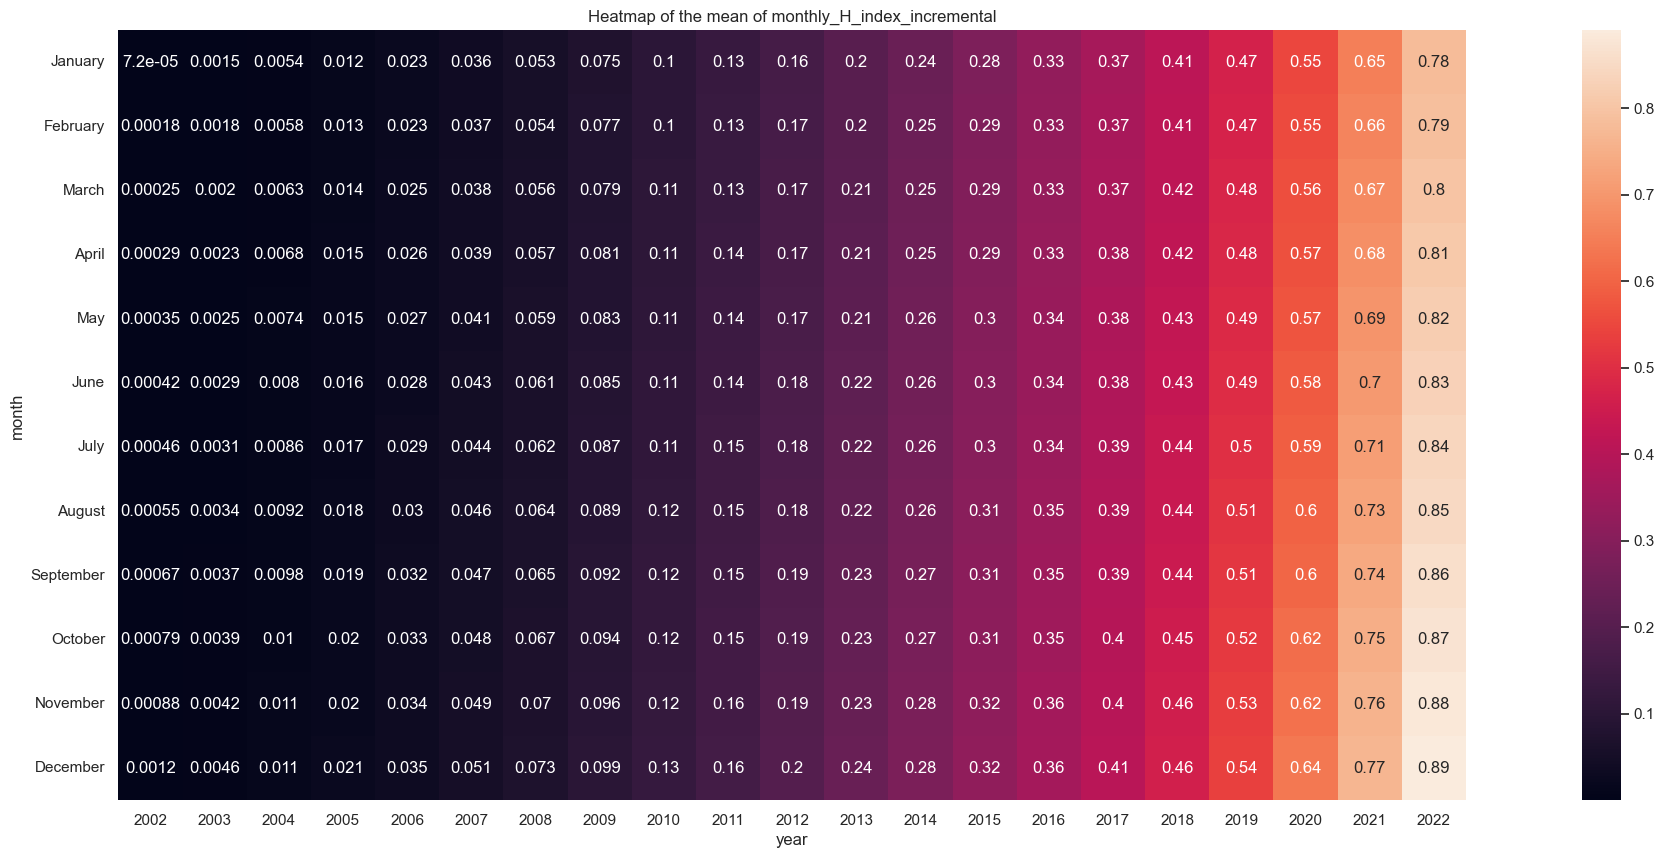

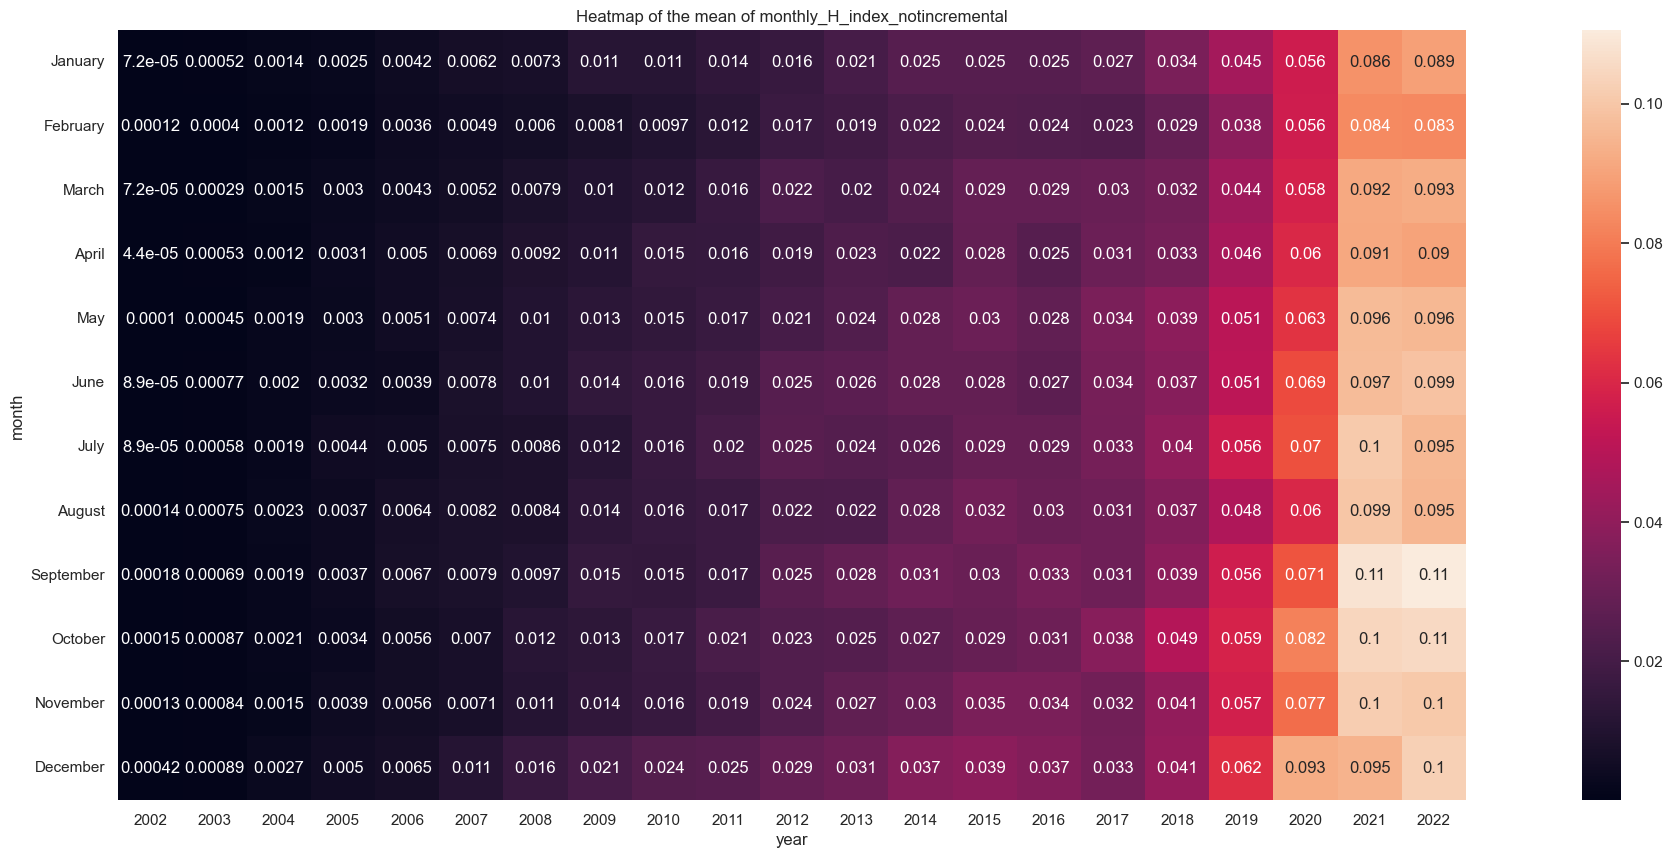

In [26]:
for column in ['yearly_H_index_notincremental','yearly_H_index_incremental','monthly_H_index_incremental','monthly_H_index_notincremental']:
    heatmap_data = pd.pivot_table(
    df_hindices, values=column, index="month", columns="year", aggfunc=np.mean
    )

    sns.set(rc={"figure.figsize": (30, 10)})
    sns.heatmap(heatmap_data, annot=True, square=True).set(
    title="Heatmap of the mean of "+str(column)
    )
    plt.show()

__Observations__

Just as planned, there is an increase of the mean of h-indices with time over the years, since there are more citations and a higher interconnectivity within the field of encryption technologies. The mean remains very low, because of all the 0 h-indices we have, because of how this dataset was constructed.

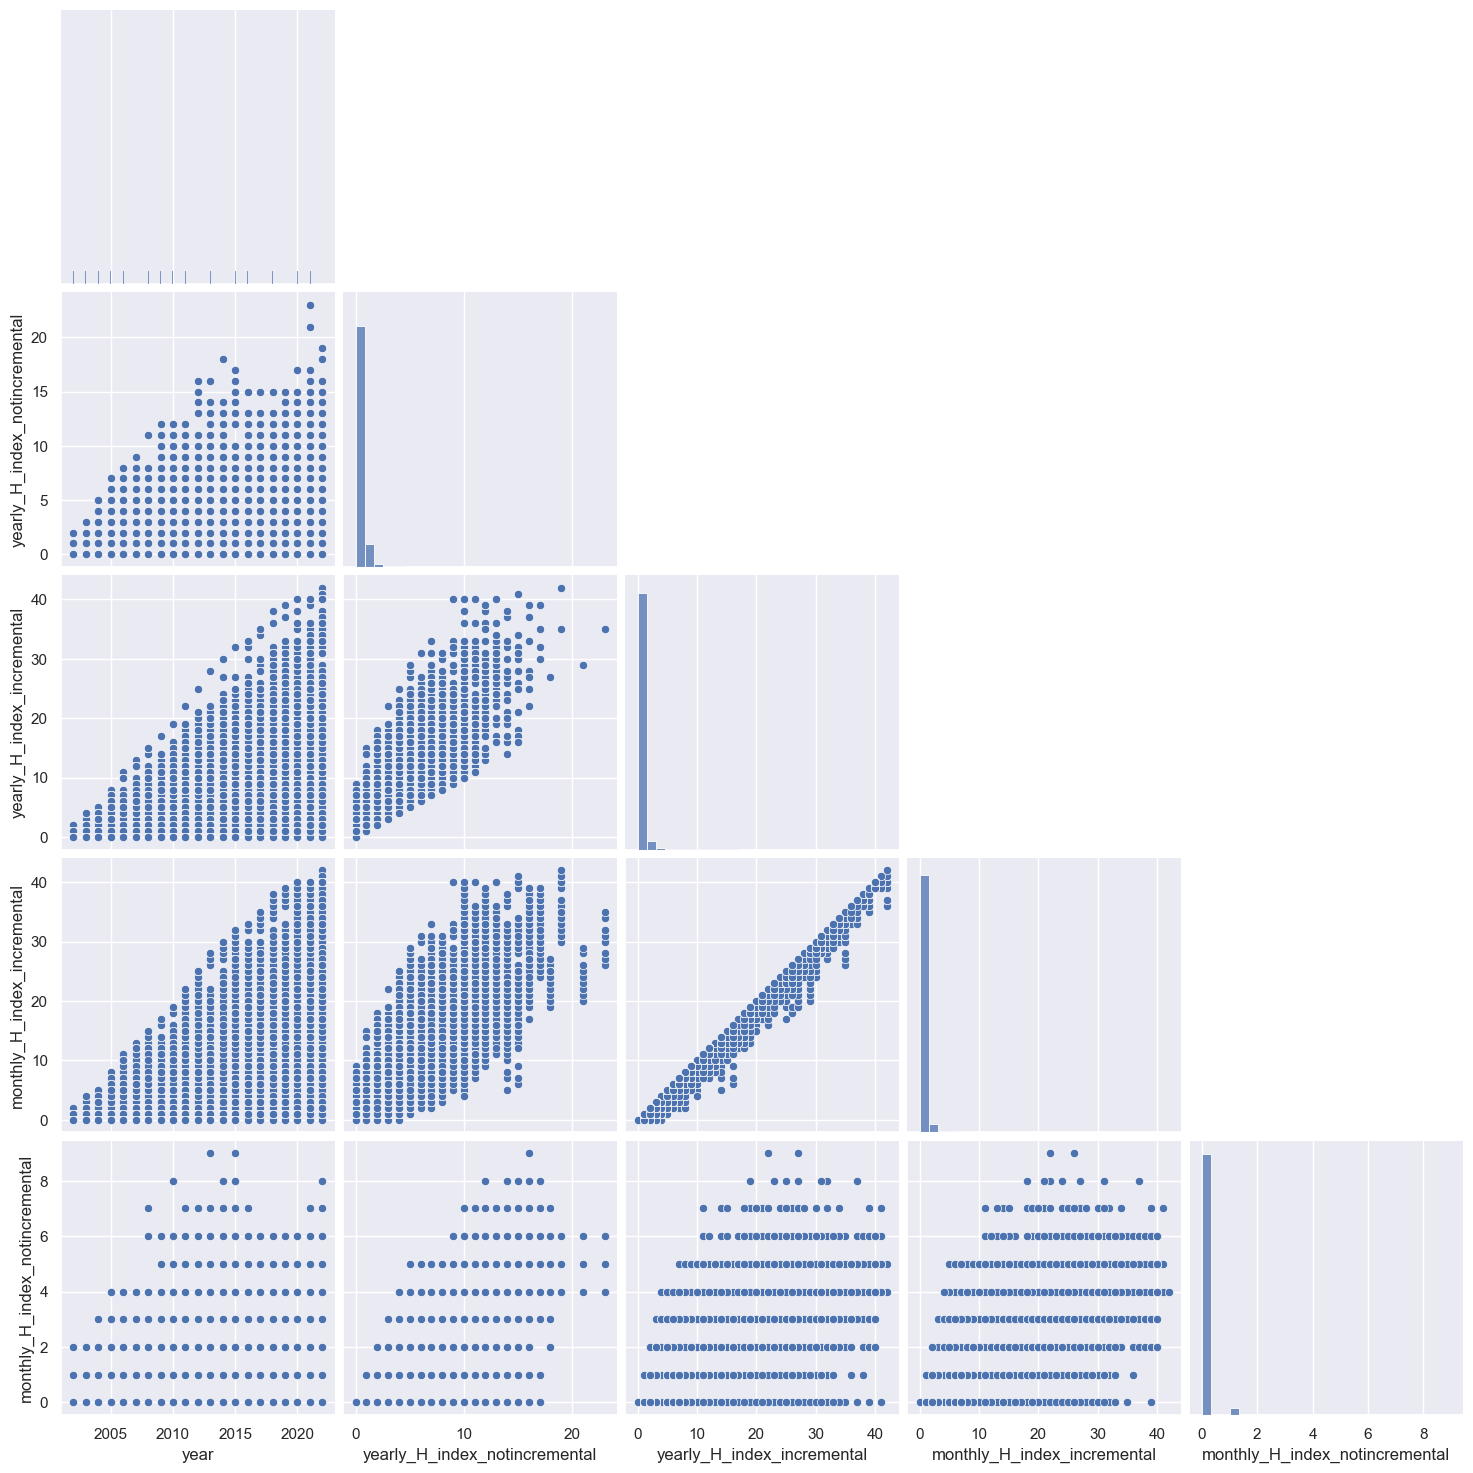

In [27]:
sns.pairplot(df_hindices, height=3, corner=True)
plt.show()

__Observations__

Just as expected, we can see that between the yearly incremental h index and the monthly incremental h index there is a high correlation. Most of the h-indices are zero, because of how the dataset was constructed. The h-indices increase with time, since the number of citations increases with time. The number of authors by year is displayed in the first graphic top left. Unfortunately, we do not see very well because of the scale, but it seems to be relatively constant. This is probably a mistake due to the scale. By the way, the axis do not all have the same scale.
Interestingly, the h index yearly not incremental seems to be a bit correlated with the monthly h-index incremental just as with the yearly h-index incremental. The rest does not seem to be very correlated, just as expected.

In [28]:
df_hindices.corr()

year  yearly_H_index_notincremental  \
year                            1.000000                       0.232115   
yearly_H_index_notincremental   0.232115                       1.000000   
yearly_H_index_incremental      0.280544                       0.826307   
monthly_H_index_incremental     0.274092                       0.784637   
monthly_H_index_notincremental  0.139816                       0.643251   

                                yearly_H_index_incremental  \
year                                              0.280544   
yearly_H_index_notincremental                     0.826307   
yearly_H_index_incremental                        1.000000   
monthly_H_index_incremental                       0.986120   
monthly_H_index_notincremental                    0.561099   

                                monthly_H_index_incremental  \
year                                               0.274092   
yearly_H_index_notincremental                      0.784637   
yearly_H_index_incremental                         0.986120   
monthly_H_index_incremental                        1.000000   
monthly_H_index_notincremental                     0.558615   

                                monthly_H_index_notincremental  
year                                                  0.139816  
yearly_H_index_notincremental                         0.643251  
yearly_H_index_incremental                            0.561099  
monthly_H_index_incremental                           0.558615  
monthly_H_index_notincremental                        1.000000

In [29]:
corr_df = pd.DataFrame(np.tril(df_hindices.corr()))

In [30]:
corr_df_lowtriangular = corr_df.where(np.tril(np.ones(corr_df.shape)).astype(bool))

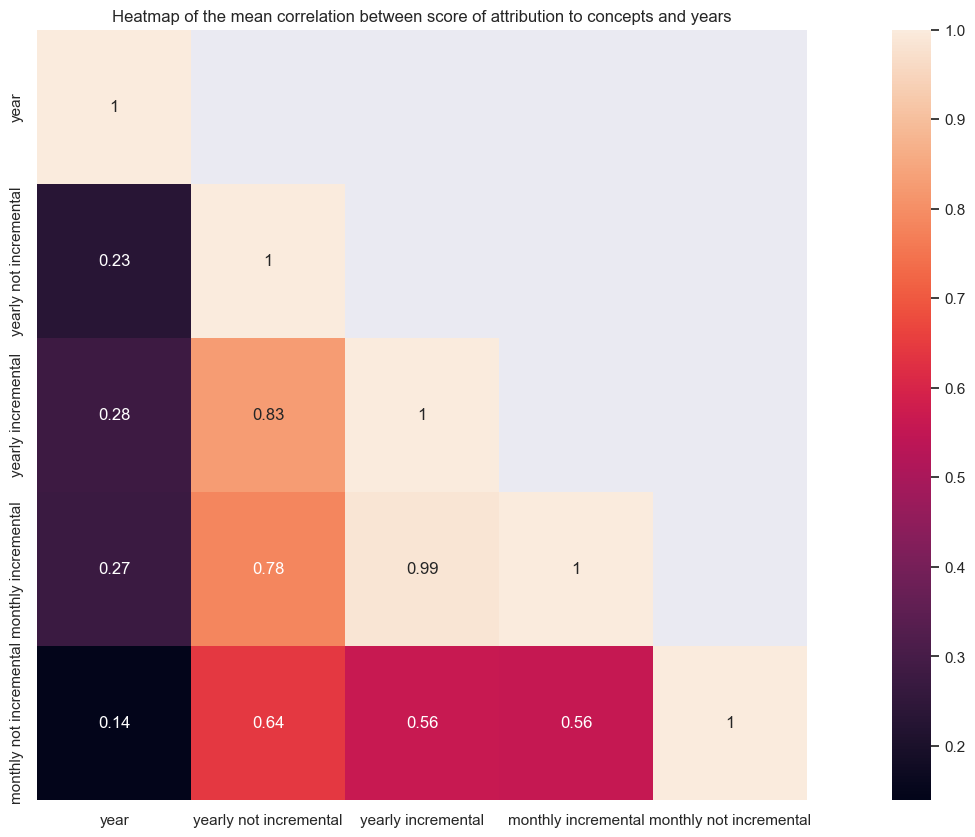

In [31]:
sns.set(rc={"figure.figsize": (22, 10)})
sns.heatmap(corr_df_lowtriangular, annot=True, square=True).set(
title="Heatmap of the mean correlation between score of attribution to concepts and years",
xticklabels=['year','yearly not incremental','yearly incremental','monthly incremental','monthly not incremental'],
yticklabels=['year','yearly not incremental','yearly incremental','monthly incremental','monthly not incremental']
)

plt.show()

__Observation__

Clearly, the variable ```year``` is not correlated with the h-indices as expected.\
Regarding the yearly not incremental h-index, we have that it is very correlated with the monthly and yearly incremental h-indices and a little correlated with monthly not incremental h-index (this is probably due to the very high concentration of zeroes everywhere).\
As expected the yearly h-index incremental is very correlated with the monthly h-index incremental. It is not very correlated with monthly not incremental h-index, as expected.\
In addition, the monthly incremental and not incremental h-indices are not very correlated, just as expected.